In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_style('white')
sns.set_context('poster')

In [5]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MIT0604', 'MIT9312', 'MED4', 'Natl2A', 'MIT9313']
ppallete = ['#f79934', '#face6e', '#62A586', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']
#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [6]:
os.listdir('6x6')

['6x6_setup.csv', 'fl_exp1.csv', 'fl_exp2.csv']

In [26]:
setup_columns = ['Sample', 'MED4', '9313', '9312', 'NATL2A', 'MIT0604', 'Syn WH8102',
       'Total tubes', 'how many in 1 tube ?']
use_setup_columns = ['Sample', 'MED4', '9313', '9312', 'NATL2A', 'MIT0604', 'Syn WH8102']

setup_df = pd.read_csv(os.path.join('6x6', '6x6_setup.csv'), names=setup_columns, usecols=use_setup_columns)

In [27]:
setup_df.dropna(axis=0, subset=['Sample'], inplace=True)

In [28]:
for c in setup_df.columns:
    setup_df[c] = pd.to_numeric(setup_df[c], downcast='integer')

In [29]:
setup_df.head()

Sample  MED4  9313  9312  NATL2A  MIT0604  Syn WH8102
2       1   1.0   NaN   NaN     NaN      NaN         NaN
3       2   NaN   2.0   NaN     NaN      NaN         NaN
4       3   NaN   NaN   3.0     NaN      NaN         NaN
5       4   NaN   NaN   NaN     4.0      NaN         NaN
6       5   NaN   NaN   NaN     NaN      5.0         NaN

In [46]:
exp1_df = pd.read_csv(os.path.join('6x6', 'fl_exp1.csv'))
exp2_df = pd.read_csv(os.path.join('6x6', 'fl_exp2.csv'))


In [47]:
exp1_df = pd.melt(exp1_df, id_vars=['Date', 'Day'], value_name='FL', var_name='Sample')
exp2_df = pd.melt(exp2_df, id_vars=['Date', 'Day'], value_name='FL', var_name='Sample')

In [56]:
exp1_df.head()

Date       Day Sample     FL sample_prefix
0  6/20/2019 12:19  0.000000     1A  0.172             1
1  6/21/2019 16:03  1.155556     1A  0.250             1
2  6/23/2019 13:56  3.067361     1A  0.482             1
3  6/24/2019 12:22  4.002083     1A  0.703             1
4   6/25/2019 9:00  4.861806     1A  0.781             1

In [49]:
exp2_df.head()

Date       Day Sample     FL
0  7/29/2019 14:54  0.000000     1A  0.009
1  7/31/2019 14:54  2.000000     1A  0.019
2   8/1/2019 12:28  2.898611     1A -0.019
3   8/4/2019 16:32  6.068056     1A  0.028
4   8/6/2019 13:10  7.927778     1A  0.009

In [72]:
exp1_df['sample_prefix'] = pd.to_numeric(exp1_df.Sample.str.rstrip('[ABCDEFGH]'))
exp2_df['sample_prefix'] = pd.to_numeric(exp2_df.Sample.str.rstrip('[ABCDEFGH]'))

In [77]:
exp1_df['experiment'] = 'e1'
exp2_df['experiment'] = 'e2'

In [78]:
setup_df.index = setup_df.Sample

In [75]:
tmp_df = setup_df.drop(columns=['Sample']).notna()

In [79]:
exp1_df = pd.merge(exp1_df, tmp_df, how='left', left_on='sample_prefix', right_index=True)
exp2_df = pd.merge(exp2_df, tmp_df, how='left', left_on='sample_prefix', right_index=True)


In [82]:
df = pd.concat([exp1_df, exp2_df])

In [83]:
df

Date        Day Sample     FL  sample_prefix experiment  \
0     6/20/2019 12:19   0.000000     1A  0.172              1         e1   
1     6/21/2019 16:03   1.155556     1A  0.250              1         e1   
2     6/23/2019 13:56   3.067361     1A  0.482              1         e1   
3     6/24/2019 12:22   4.002083     1A  0.703              1         e1   
4      6/25/2019 9:00   4.861806     1A  0.781              1         e1   
...               ...        ...    ...    ...            ...        ...   
2074  8/11/2019 10:30  12.816667    63C  0.057             63         e2   
2075  8/13/2019 11:10  14.844444    63C  0.095             63         e2   
2076  8/15/2019 14:13  16.971528    63C  0.174             63         e2   
2077  8/18/2019 12:04  19.881944    63C  0.511             63         e2   
2078  8/20/2019 11:08  21.843056    63C  0.917             63         e2   

      MED4   9313   9312  NATL2A  MIT0604  Syn WH8102  
0     True  False  False   False    False       False  
1     True  False  False   False    False       False  
2     True  False  False   False    False       False  
3     True  False  False   False    False       False  
4     True  False  False   False    False       False  
...    ...    ...    ...     ...      ...         ...  
2074  True   True   True    True     True        True  
2075  True   True   True    True     True        True  
2076  True   True   True    True     True        True  
2077  True   True   True    True     True        True  
2078  True   True   True    True     True        True  

[8883 rows x 12 columns]

In [6]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [7]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [8]:
df = pd.read_pickle('CCPA.pkl.gz')

In [9]:
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [10]:
dfc = df.loc[(df.experiment.isin(['e1','e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [11]:
def convert_func(t0, x_col='day', value_col='FL', rolling_period='1d', resample_period='1d' ):
    # x_col='day'
    # rolling_period='3d'
    # resample_period='1d'
    # value_col='FL'
    t = t0
    maxday = t.loc[t[value_col] == t[value_col].max(), x_col].values[0]
    t.loc[:, x_col] = t.loc[:, x_col] - maxday

    t.index = pd.to_timedelta(t[x_col], unit='d')
    #t.sort_index(ascending=True, inplace=True)
    t1 = t.rolling(rolling_period, min_periods=1).agg({value_col : 'mean'})
    t2 = t1.resample(resample_period).agg({value_col : 'mean'})
    t2.index= t2.index.astype('timedelta64[D]')
    t3 = t2.interpolate(method='from_derivatives', limit_area='inside')
    return t3


In [12]:
groupby_cols = ['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture']
ds  = dfc.groupby(groupby_cols).apply(convert_func).reset_index() 

In [13]:
# ds.day = ds.day.astype('timedelta64[D]')
ds = ds.loc[(ds.day < 81) & (ds.day > -11)]

In [14]:
ds.head()

experiment_sample experiment sample      PRO ALT     culture  day       FL
5           e1, 10A         e1    10A  MIT0604  DE  Co_Culture  -10  0.37325
6           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -9  0.44400
7           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -8  0.69700
8           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -7  0.95000
9           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -6  1.20300

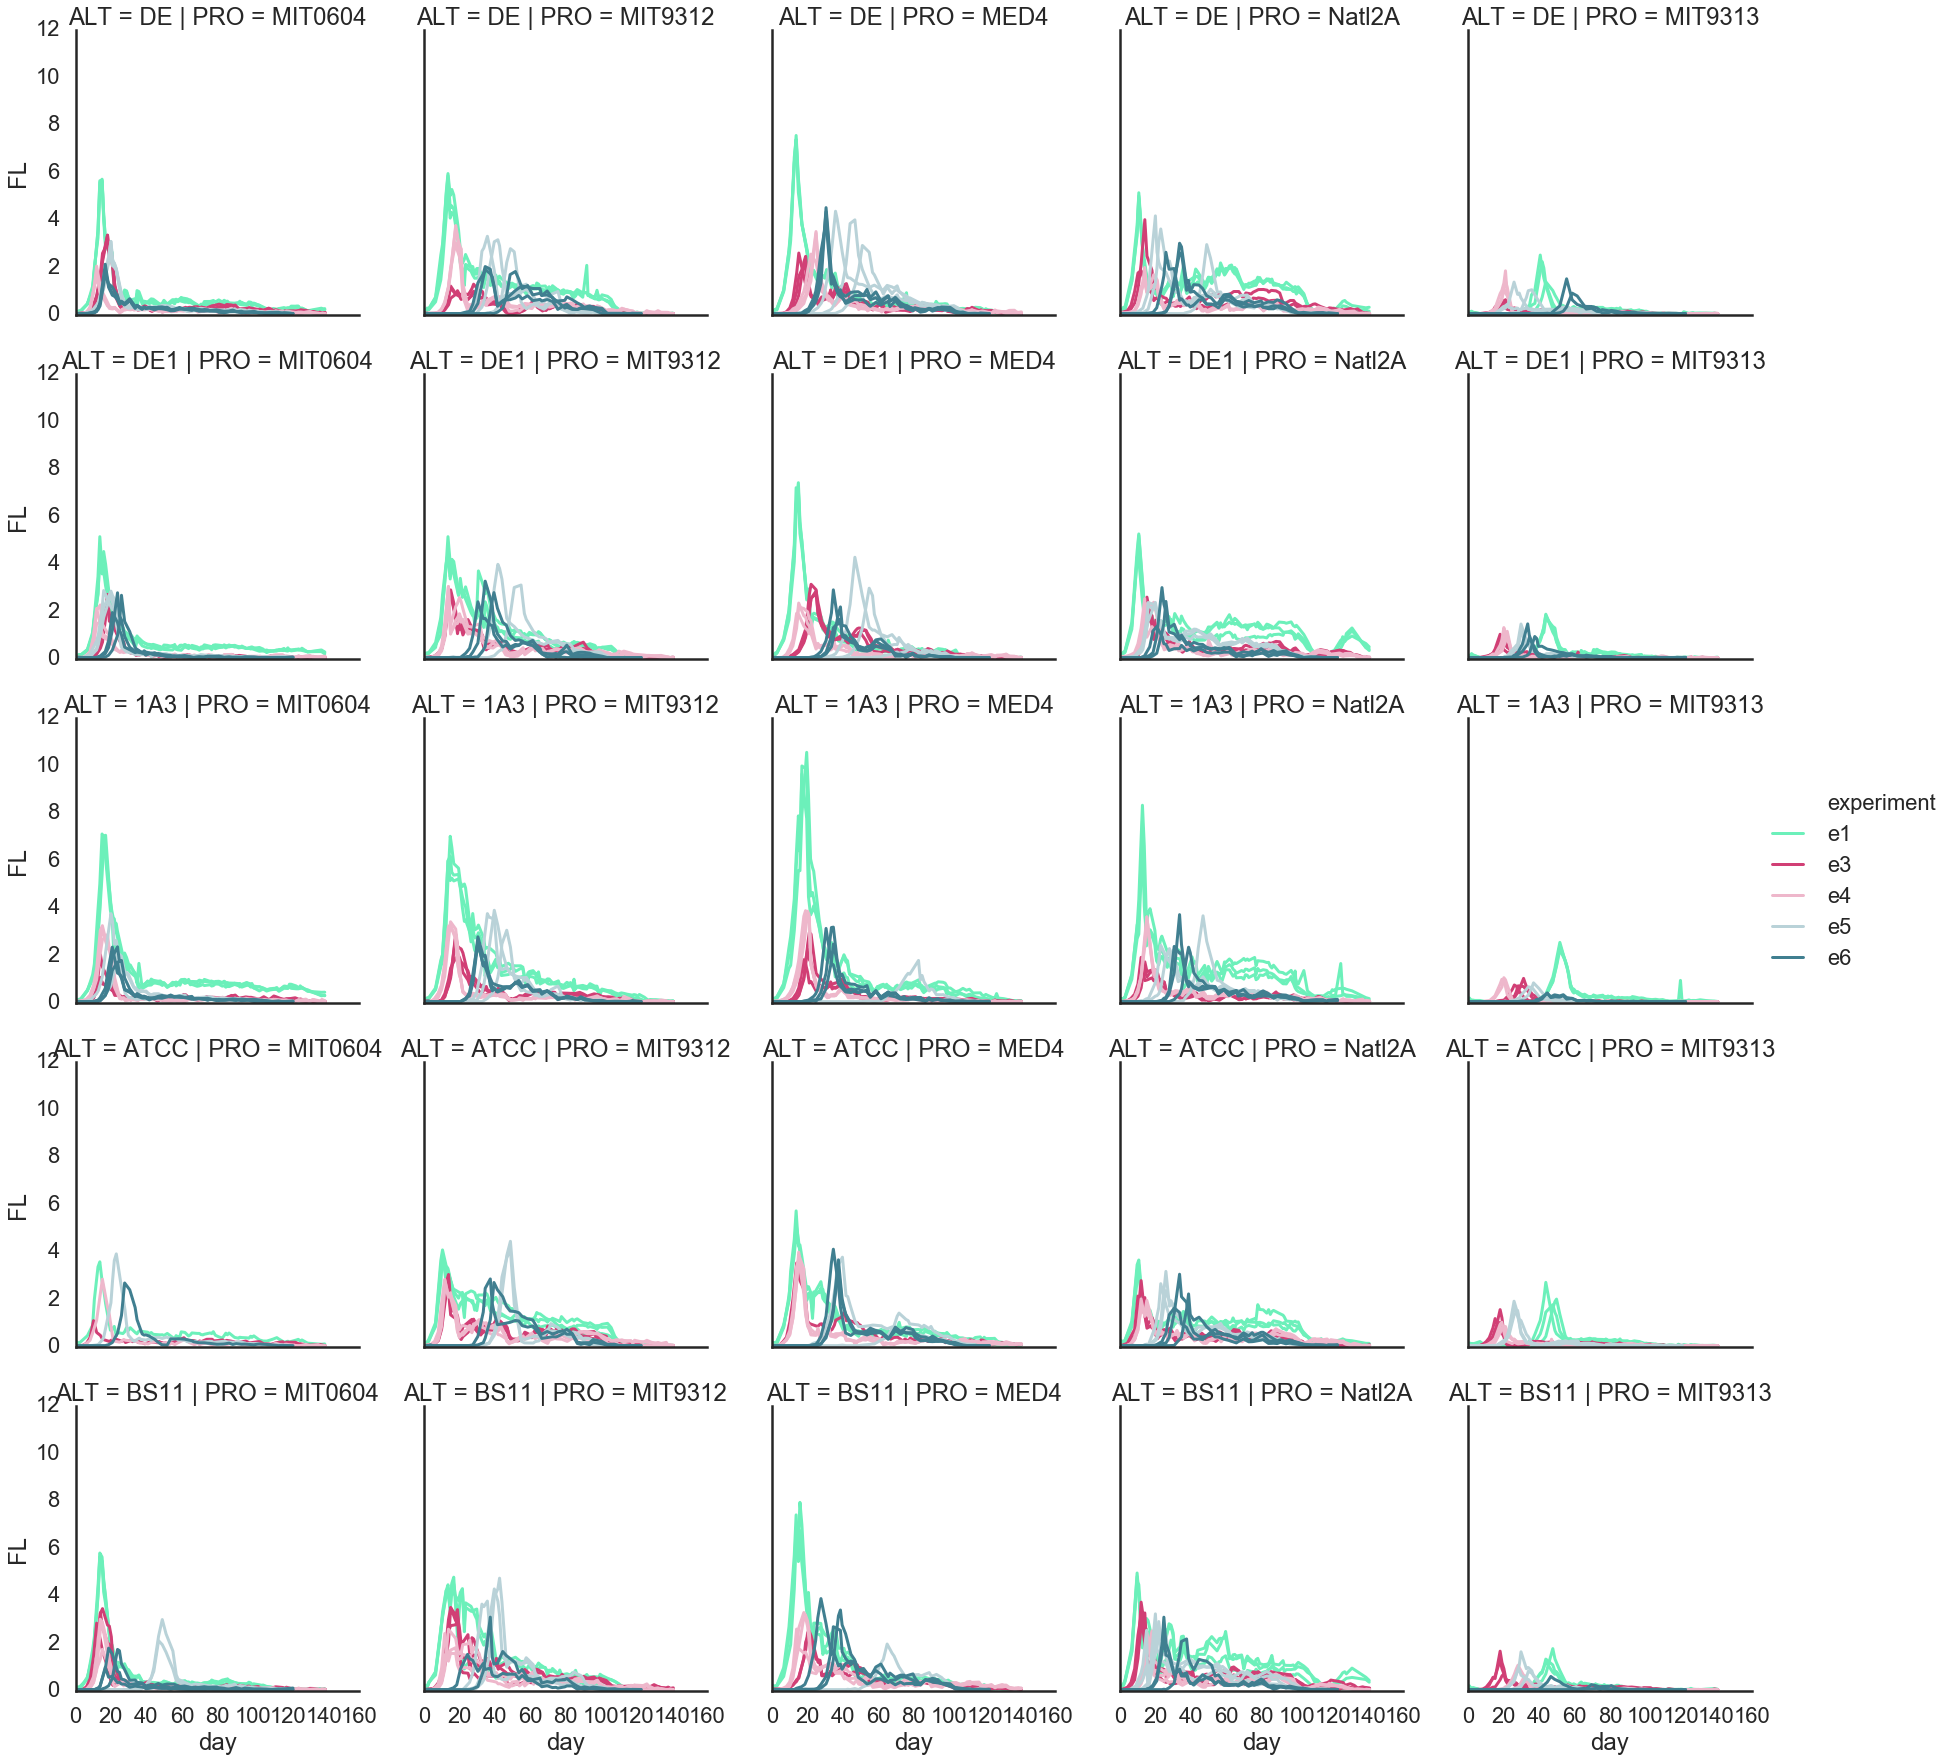

In [15]:
sns.relplot(data=dfc, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT', row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)

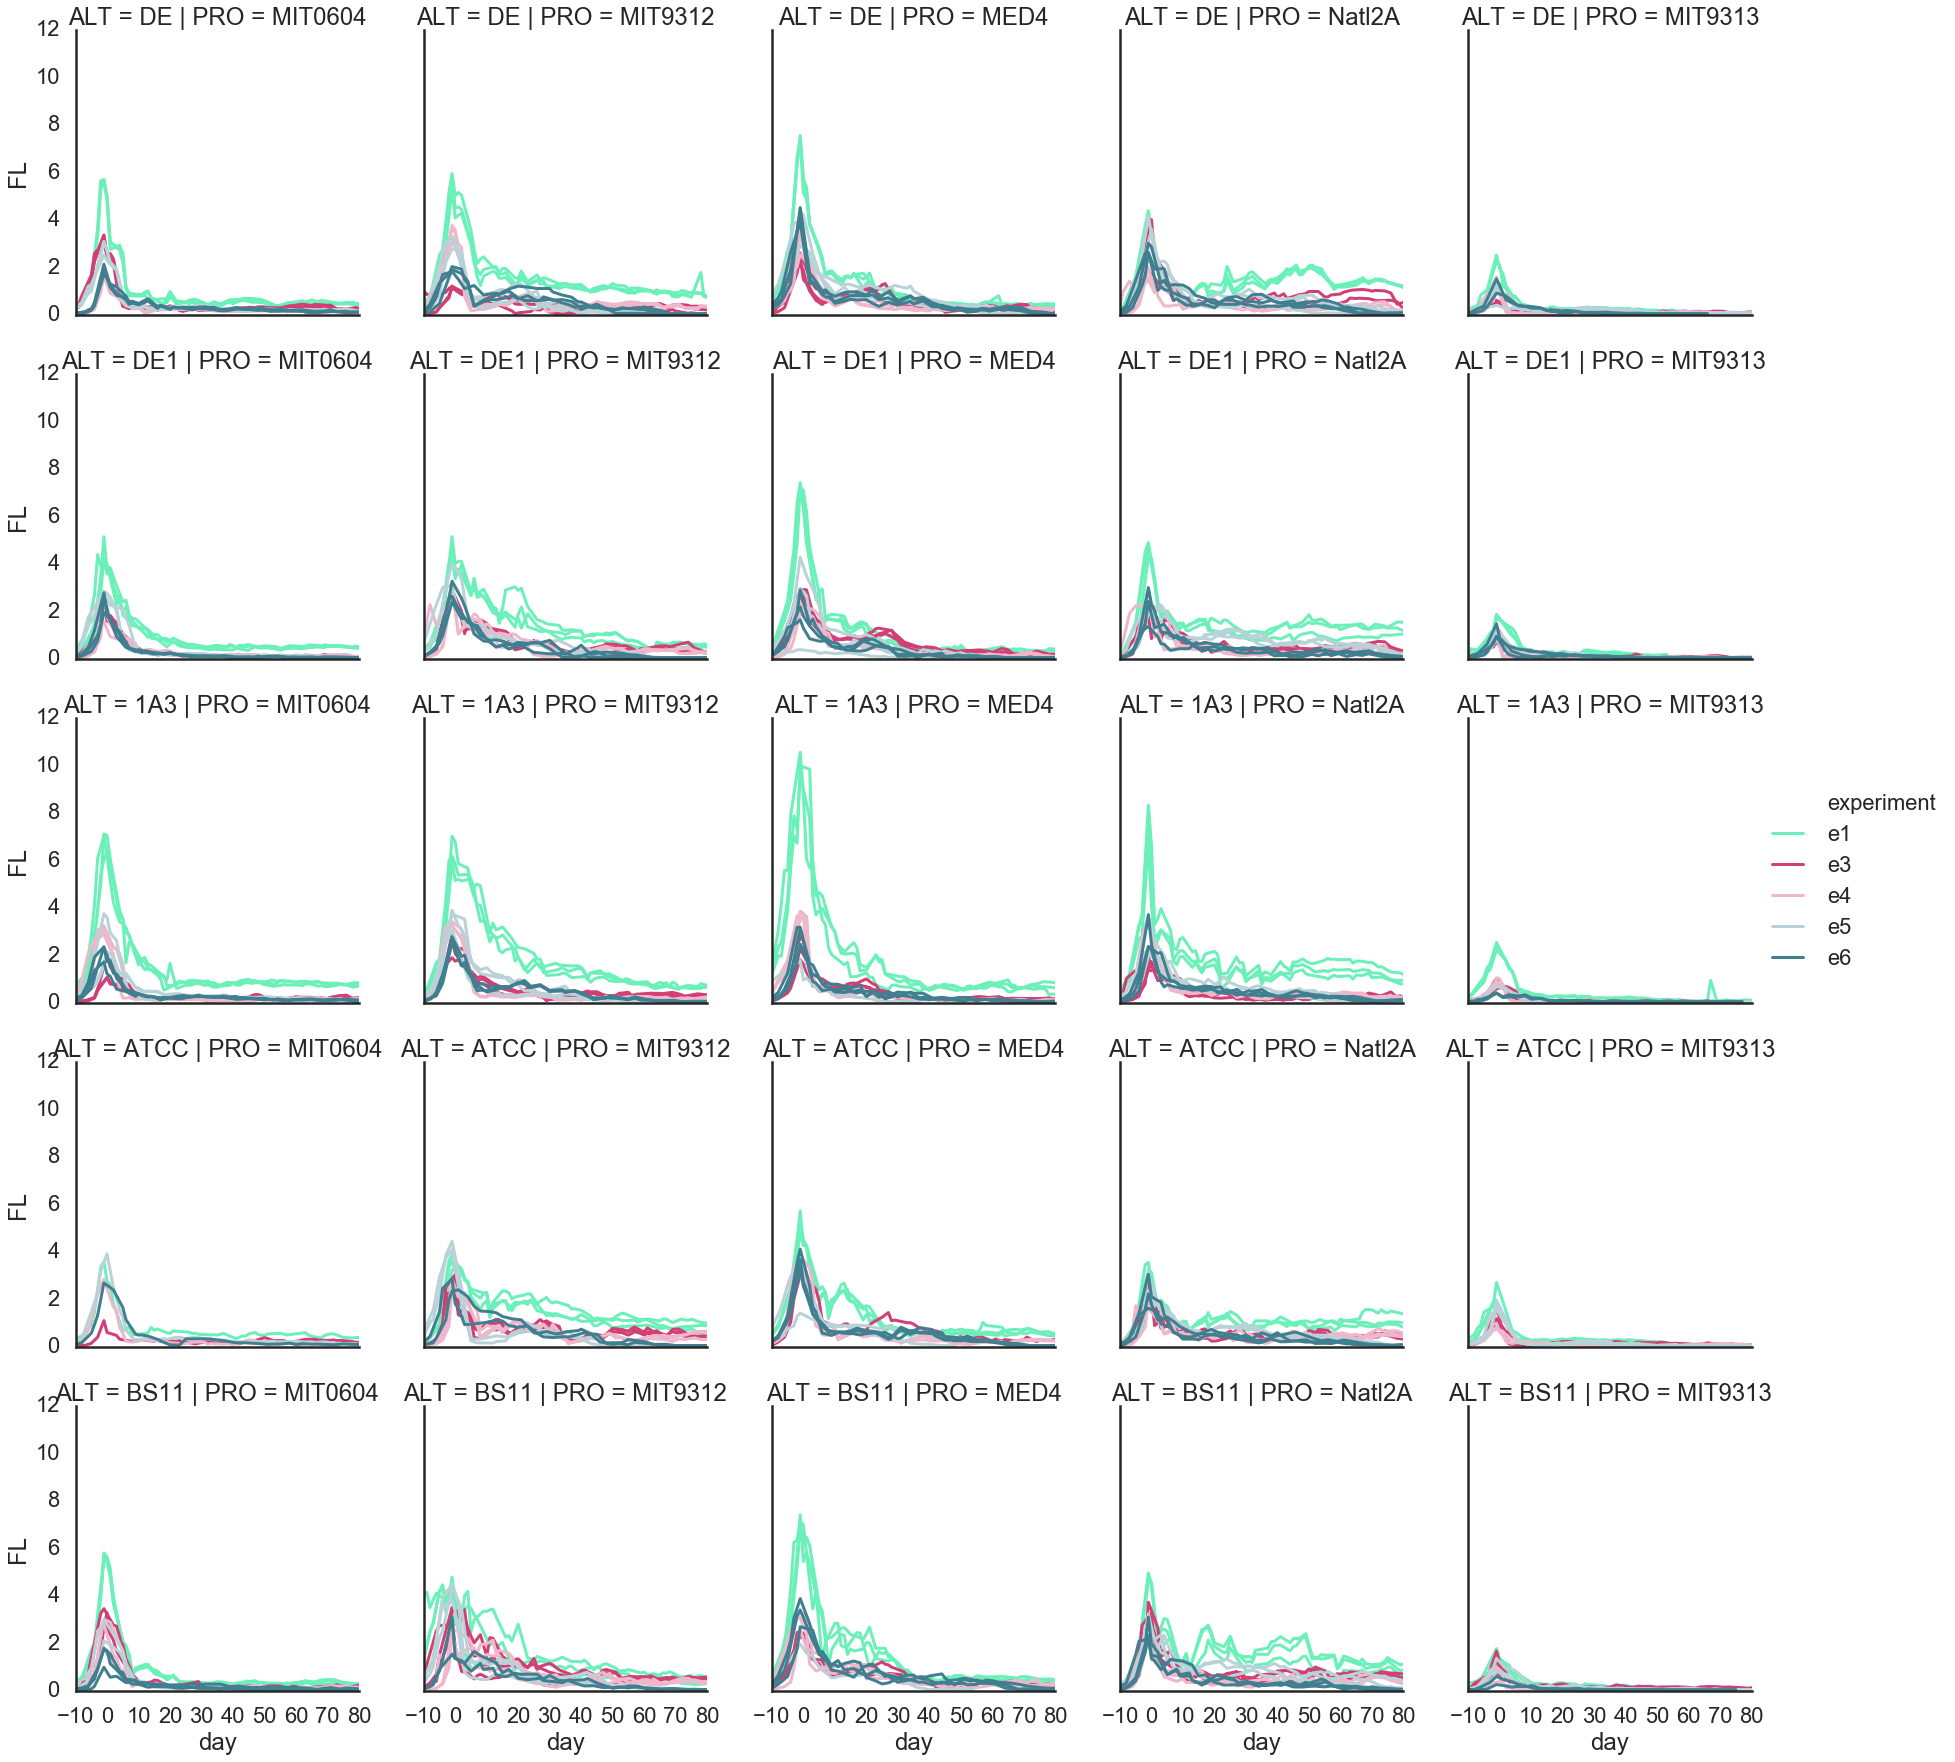

In [16]:
sns.relplot(data=ds, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT',
            row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)

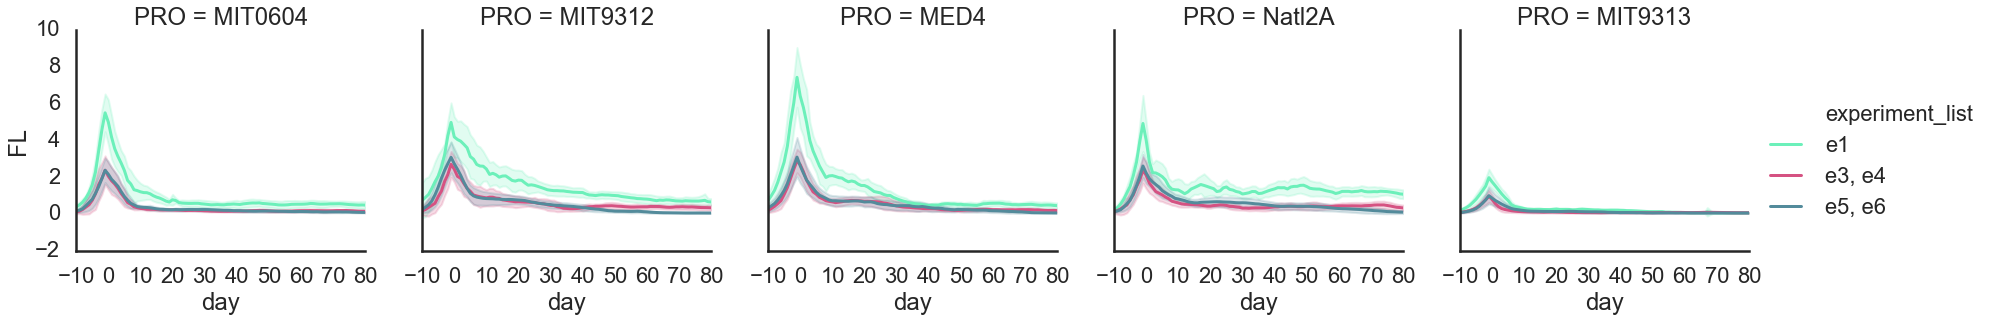

In [19]:
ds['experiment_list'] = ''
ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'
ds.loc[ds.experiment.isin(['e1']), 'experiment_list'] = 'e1'


g = sns.relplot(data=ds, hue='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', #aspect=1.8,
            x='day', y='FL', kind='line', col='PRO', #legend=False, 
            #hue_order=porder, 
                palette=espallete,
                col_order=porder,
               )
#g.set(yscale='log')

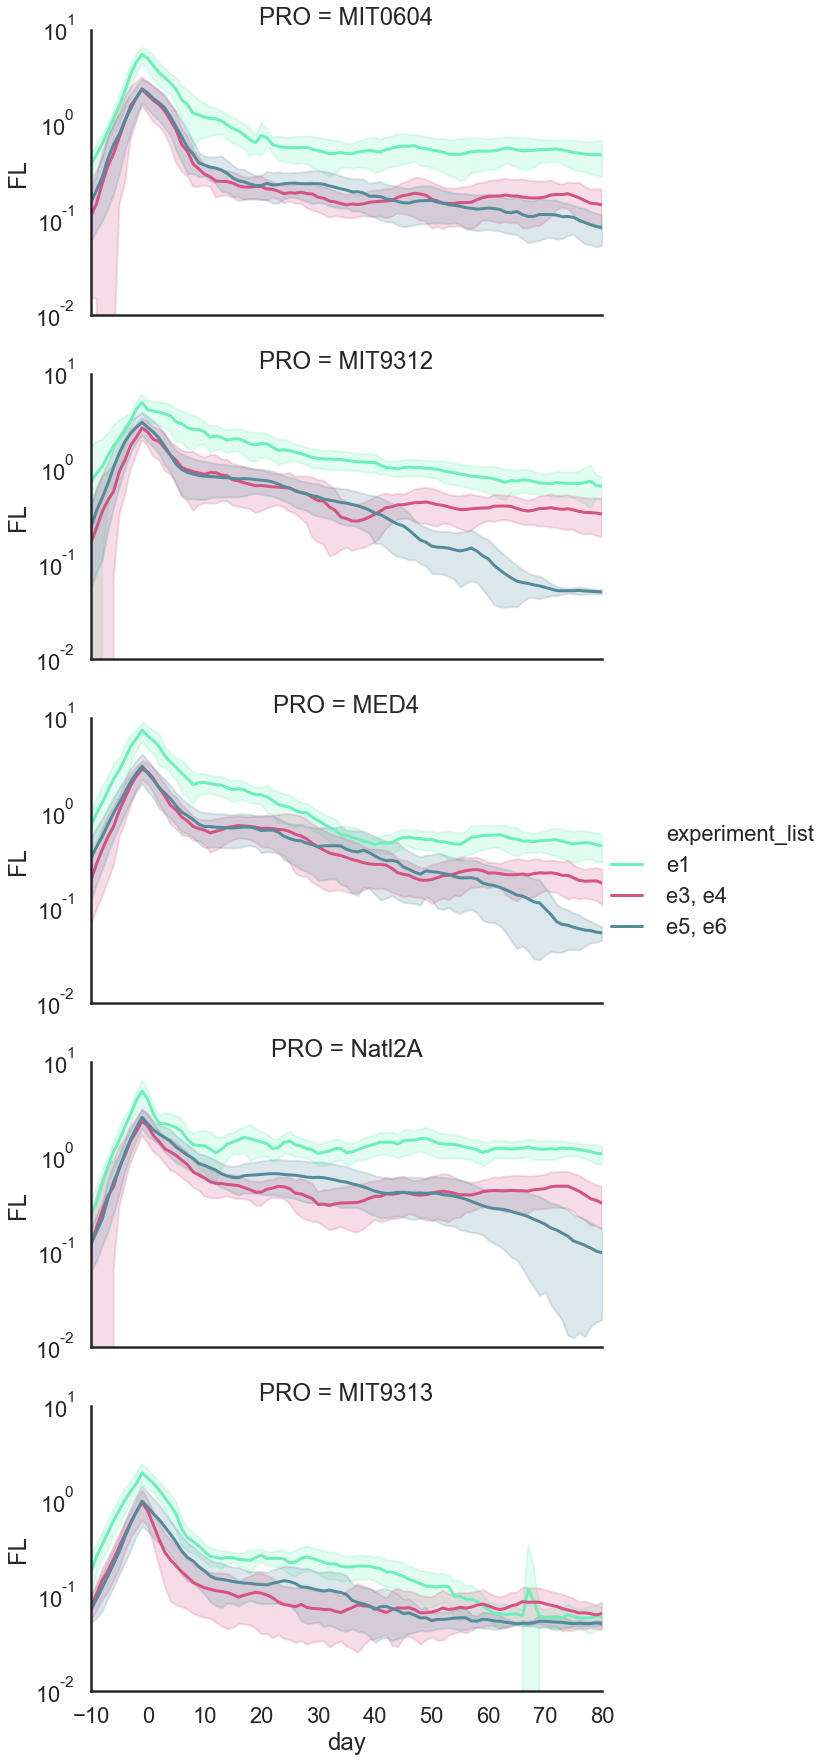

In [20]:
#ds['experiment_list'] = ''
#ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
#ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'


g = sns.relplot(data=ds, hue='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8,
            x='day', y='FL', kind='line', row='PRO', #legend=False, 
            #hue_order=porder, 
                palette=espallete,
                row_order=porder
               )
g.set(yscale='log')

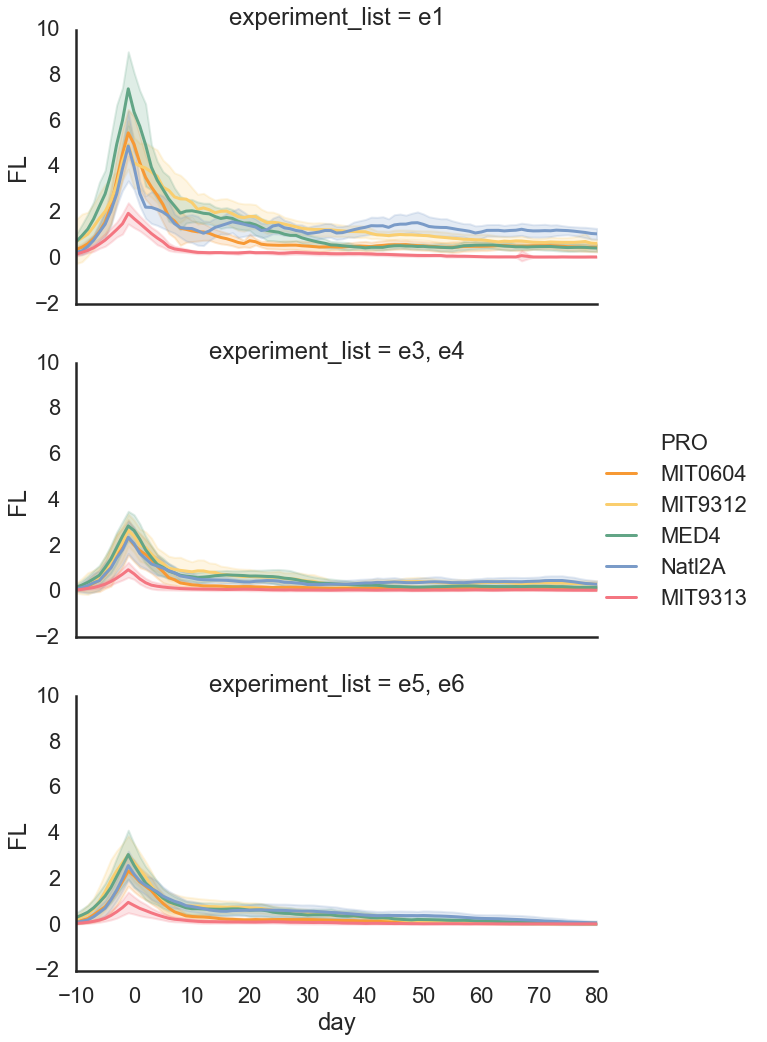

In [21]:
g = sns.relplot(data=ds, row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8,
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
            hue_order=porder, palette=ppallete)
#g.set(yscale='log')

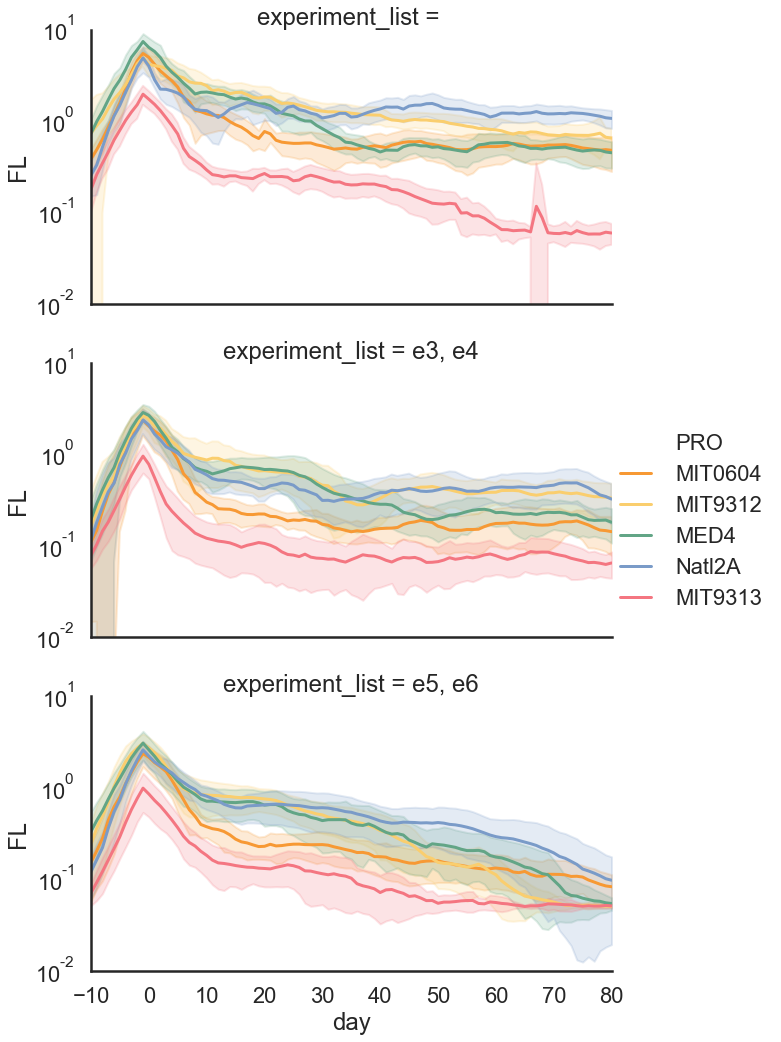

In [22]:
ds['experiment_list'] = ''
ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'


g = sns.relplot(data=ds, row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8,
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
            hue_order=porder, palette=ppallete)
g.set(yscale='log')

In [23]:
ds['decline'] = ds['FL']

In [24]:
ds1 = ds.loc[ds.experiment.isin(['e1'])]
ds34 = ds.loc[ds.experiment.isin(['e3', 'e4'])]
ds56 = ds.loc[ds.experiment.isin(['e5', 'e6'])]

In [64]:
ds1 = ds1.loc[ds1['sample'] != '25C']
ds34 = ds34.loc[ds34['sample'] != '25C']
ds56 = ds56.loc[ds56['sample'] != '25C']


In [65]:
ds34.head()

experiment_sample experiment sample      PRO ALT     culture  day  \
10344           e3, 10A         e3    10A  MIT0604  DE  Co_Culture  -10   
10345           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -9   
10346           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -8   
10347           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -7   
10348           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -6   

          FL experiment_list  decline  
10344  0.299          e3, e4    0.299  
10345  0.381          e3, e4    0.381  
10346  0.693          e3, e4    0.693  
10347  0.959          e3, e4    0.959  
10348  1.225          e3, e4    1.225

In [66]:
train1_df_orig, test1_df_orig = cp.split_train_test(ds1,test_size=0.4)
train34_df_orig, test34_df_orig = cp.split_train_test(ds34,test_size=0.4)
train56_df_orig, test56_df_orig = cp.split_train_test(ds56,test_size=0.4)

In [67]:
test1_df_orig.groupby(['PRO', 'ALT'])['sample'].unique()

PRO      ALT 
MED4     1A3           [1A]
         ATCC         [21A]
         BS11         [16A]
         DE            [6B]
         DE1          [11A]
MIT0604  1A3           [5B]
         BS11         [20C]
         DE           [10A]
         DE1          [15B]
MIT9312  1A3           [3C]
         ATCC    [23A, 23B]
         BS11    [18A, 18B]
         DE            [8B]
         DE1     [13A, 13B]
MIT9313  1A3           [2A]
         ATCC         [22C]
         BS11    [17B, 17C]
         DE            [7A]
         DE1          [12B]
Natl2A   1A3           [4C]
         ATCC         [24B]
         BS11    [19A, 19B]
         DE            [9A]
         DE1          [14C]
Name: sample, dtype: object

In [69]:
train1_df = cp.augment_training(train1_df_orig, noise_N=3, augment_x=False)
test1_df = test1_df_orig
train34_df = cp.augment_training(train34_df_orig, noise_N=3, augment_x=False)
test34_df = test34_df_orig
train56_df = cp.augment_training(train56_df_orig, noise_N=3, augment_x=False)
test56_df = test56_df_orig

In [70]:
train1_df.shape, test1_df.shape, train34_df.shape, test34_df.shape, train56_df.shape, test56_df.shape, 

((328692, 10), (2639, 10), (634452, 10), (5096, 10), (564564, 10), (4508, 10))

In [71]:
train34_df.columns

Index(['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture',
       'day', 'FL', 'augment_name', 'experiment_sample_orig'],
      dtype='object')

In [72]:
stats34_list = []
y34_list = []
clf34_list = []
features34_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train34_df, test34_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats34_list.extend(res)
y34_list.extend(_y_list)
clf34_list.extend(_clf_list)
features34_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0


In [73]:
stats56_list = []
y56_list = []
clf56_list = []
features56_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train56_df, test56_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats56_list.extend(res)
y56_list.extend(_y_list)
clf56_list.extend(_clf_list)
features56_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0


In [74]:
stats1_list = []
y1_list = []
clf1_list = []
features1_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train1_df, test1_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats1_list.extend(res)
y1_list.extend(_y_list)
clf1_list.extend(_clf_list)
features1_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0


In [75]:
stats56_df = pd.DataFrame.from_records(stats56_list)
stats34_df = pd.DataFrame.from_records(stats34_list)
stats1_df = pd.DataFrame.from_records(stats1_list)


In [76]:
stats56_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
8   0.756030       0.764706             1.0
3   0.735788       0.745098             1.0
19  0.730696       0.745098             1.0
25  0.712022       0.725490             1.0
10  0.711540       0.725490             1.0
29  0.710414       0.725490             1.0
27  0.710414       0.725490             1.0
24  0.710414       0.725490             1.0
7   0.710414       0.725490             1.0
12  0.710414       0.725490             1.0

In [77]:
stats34_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
25  0.929208       0.928571             1.0
29  0.890230       0.892857             1.0
26  0.890230       0.892857             1.0
11  0.890230       0.892857             1.0
16  0.890230       0.892857             1.0
28  0.889641       0.892857             1.0
1   0.872514       0.875000             1.0
27  0.872514       0.875000             1.0
23  0.872514       0.875000             1.0
22  0.872514       0.875000             1.0

In [78]:
stats1_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
0   0.966284       0.965517             1.0
1   0.966284       0.965517             1.0
28  0.966284       0.965517             1.0
27  0.966284       0.965517             1.0
26  0.966284       0.965517             1.0
25  0.966284       0.965517             1.0
24  0.966284       0.965517             1.0
23  0.966284       0.965517             1.0
22  0.966284       0.965517             1.0
21  0.966284       0.965517             1.0

In [87]:
idx34 = 25
y34_df =  y34_list[idx34]
clf34 = clf34_list[idx34]
features34 = features34_list[idx34]

In [88]:
y34_df.head()

PRO_FL_y PRO_FL_y_PRO PRO_FL_y_pred  \
experiment_sample                                               
e3, 10A, FL_0.05_0_first   MIT0604      MIT0604       MIT0604   
e3, 10A, FL_0.05_0_last    MIT0604      MIT0604       MIT0604   
e3, 10A, FL_0.05_0_max     MIT0604      MIT0604       MIT0604   
e3, 10A, FL_0.05_0_mean    MIT0604      MIT0604       MIT0604   
e3, 10A, FL_0.05_0_median  MIT0604      MIT0604       MIT0604   

                          PRO_FL_y_pred_PRO   Type  
experiment_sample                                   
e3, 10A, FL_0.05_0_first            MIT0604  Train  
e3, 10A, FL_0.05_0_last             MIT0604  Train  
e3, 10A, FL_0.05_0_max              MIT0604  Train  
e3, 10A, FL_0.05_0_mean             MIT0604  Train  
e3, 10A, FL_0.05_0_median           MIT0604  Train

accuracy: 0.9285714285714286
              precision    recall  f1-score   support

        MED4       1.00      1.00      1.00        11
     MIT0604       0.77      1.00      0.87        10
     MIT9312       1.00      0.82      0.90        11
     MIT9313       1.00      1.00      1.00        11
      Natl2A       0.92      0.85      0.88        13

    accuracy                           0.93        56
   macro avg       0.94      0.93      0.93        56
weighted avg       0.94      0.93      0.93        56



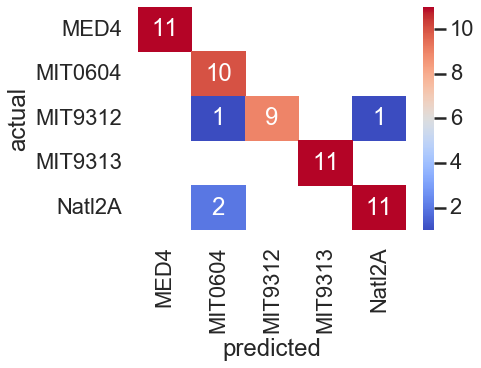

In [89]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y34_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


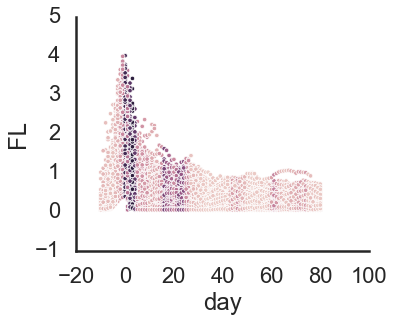

In [90]:
feature_importances34 = pd.DataFrame(clf34.feature_importances_,
                                   index = features34,
                                    columns=['importance'])
merge34df = ds34.merge(feature_importances34, left_on='day', right_index=True, how='left')
sns.relplot(data=merge34df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)

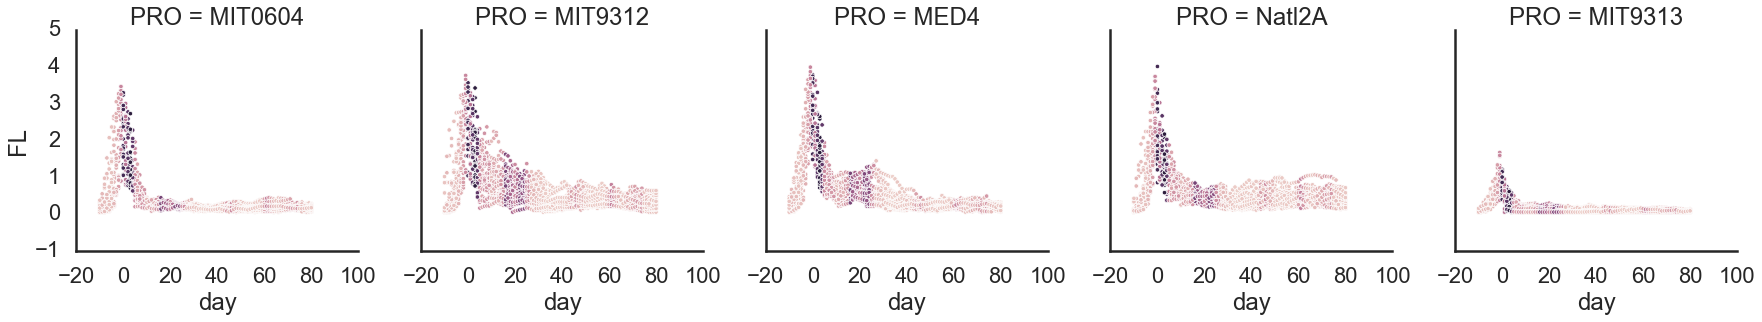

In [91]:
sns.relplot(data=merge34df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

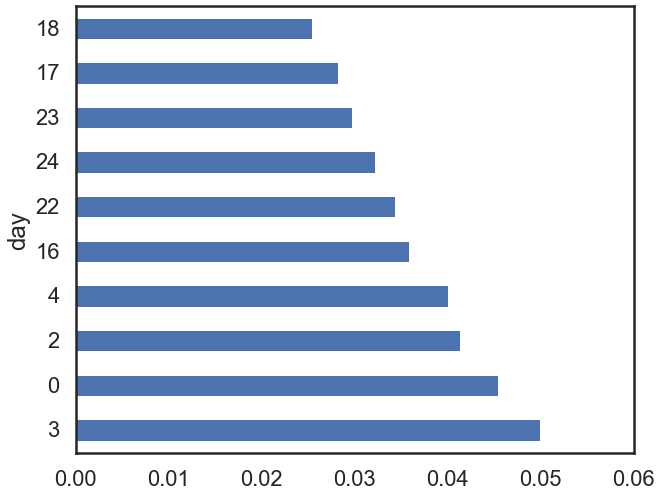

In [92]:
feature_importances34.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [93]:
stats56_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
8   0.756030       0.764706             1.0
3   0.735788       0.745098             1.0
19  0.730696       0.745098             1.0
25  0.712022       0.725490             1.0
10  0.711540       0.725490             1.0
29  0.710414       0.725490             1.0
27  0.710414       0.725490             1.0
24  0.710414       0.725490             1.0
7   0.710414       0.725490             1.0
12  0.710414       0.725490             1.0

In [94]:
idx56 = 8
y56_df =  y56_list[idx56]
clf56 = clf56_list[idx56]
features56 = features56_list[idx56]

In [95]:
y56_df.head()

PRO_FL_y PRO_FL_y_PRO PRO_FL_y_pred  \
experiment_sample                                               
e5, 10A, FL_0.05_0_first   MIT0604      MIT0604       MIT0604   
e5, 10A, FL_0.05_0_last    MIT0604      MIT0604       MIT0604   
e5, 10A, FL_0.05_0_max     MIT0604      MIT0604       MIT0604   
e5, 10A, FL_0.05_0_mean    MIT0604      MIT0604       MIT0604   
e5, 10A, FL_0.05_0_median  MIT0604      MIT0604       MIT0604   

                          PRO_FL_y_pred_PRO   Type  
experiment_sample                                   
e5, 10A, FL_0.05_0_first            MIT0604  Train  
e5, 10A, FL_0.05_0_last             MIT0604  Train  
e5, 10A, FL_0.05_0_max              MIT0604  Train  
e5, 10A, FL_0.05_0_mean             MIT0604  Train  
e5, 10A, FL_0.05_0_median           MIT0604  Train

accuracy: 0.7647058823529411
              precision    recall  f1-score   support

        MED4       0.62      0.50      0.56        10
     MIT0604       0.88      0.78      0.82         9
     MIT9312       0.75      0.55      0.63        11
     MIT9313       1.00      1.00      1.00        10
      Natl2A       0.65      1.00      0.79        11

    accuracy                           0.76        51
   macro avg       0.78      0.76      0.76        51
weighted avg       0.77      0.76      0.76        51



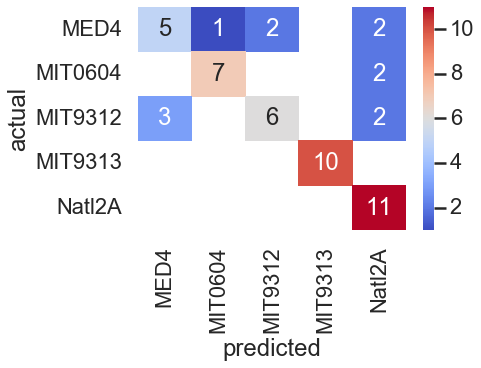

In [96]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y56_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


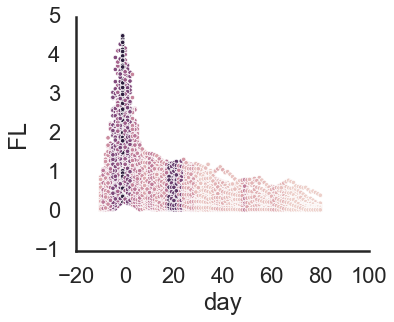

In [97]:
feature_importances56 = pd.DataFrame(clf56.feature_importances_,
                                   index = features56,
                                    columns=['importance'])
merge56df = ds56.merge(feature_importances56, left_on='day', right_index=True, how='left')
sns.relplot(data=merge56df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)

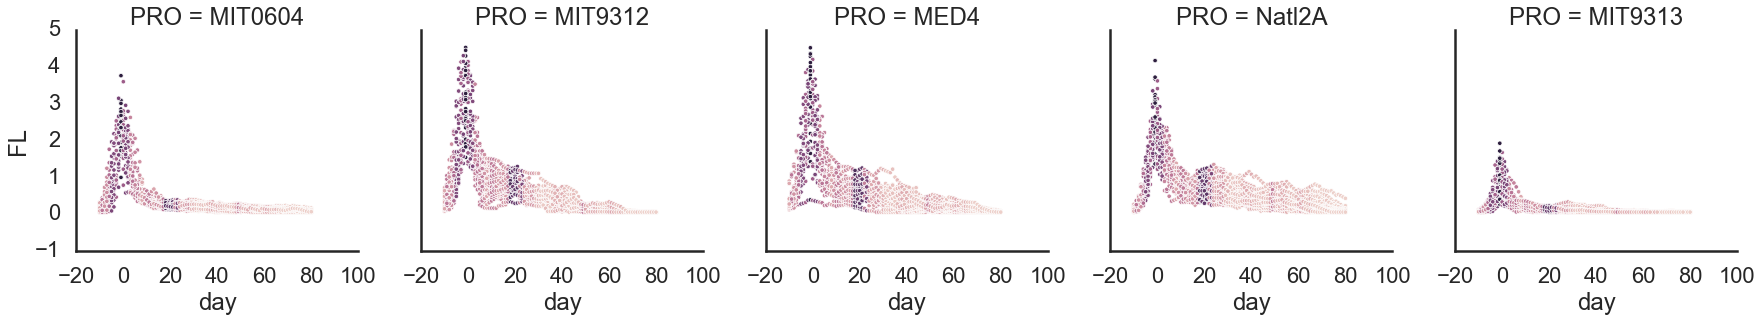

In [98]:
sns.relplot(data=merge56df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

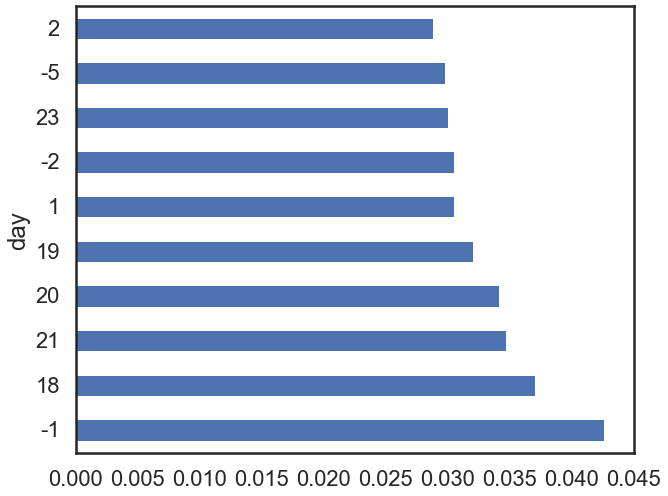

In [99]:
feature_importances56.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [100]:
stats1_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
0   0.966284       0.965517             1.0
1   0.966284       0.965517             1.0
28  0.966284       0.965517             1.0
27  0.966284       0.965517             1.0
26  0.966284       0.965517             1.0
25  0.966284       0.965517             1.0
24  0.966284       0.965517             1.0
23  0.966284       0.965517             1.0
22  0.966284       0.965517             1.0
21  0.966284       0.965517             1.0

In [101]:
idx1 = 0
y1_df =  y1_list[idx1]
clf1 = clf1_list[idx1]
features1 = features1_list[idx1]

In [102]:
y1_df.head()

PRO_FL_y PRO_FL_y_PRO PRO_FL_y_pred  \
experiment_sample                                               
e1, 10B, FL_0.05_0_first   MIT0604      MIT0604       MIT0604   
e1, 10B, FL_0.05_0_last    MIT0604      MIT0604       MIT0604   
e1, 10B, FL_0.05_0_max     MIT0604      MIT0604       MIT0604   
e1, 10B, FL_0.05_0_mean    MIT0604      MIT0604       MIT0604   
e1, 10B, FL_0.05_0_median  MIT0604      MIT0604       MIT0604   

                          PRO_FL_y_pred_PRO   Type  
experiment_sample                                   
e1, 10B, FL_0.05_0_first            MIT0604  Train  
e1, 10B, FL_0.05_0_last             MIT0604  Train  
e1, 10B, FL_0.05_0_max              MIT0604  Train  
e1, 10B, FL_0.05_0_mean             MIT0604  Train  
e1, 10B, FL_0.05_0_median           MIT0604  Train

accuracy: 0.9655172413793104
              precision    recall  f1-score   support

        MED4       1.00      1.00      1.00         5
     MIT0604       0.80      1.00      0.89         4
     MIT9312       1.00      0.88      0.93         8
     MIT9313       1.00      1.00      1.00         6
      Natl2A       1.00      1.00      1.00         6

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



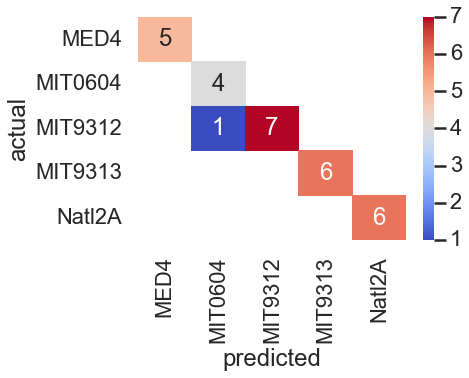

In [103]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y1_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


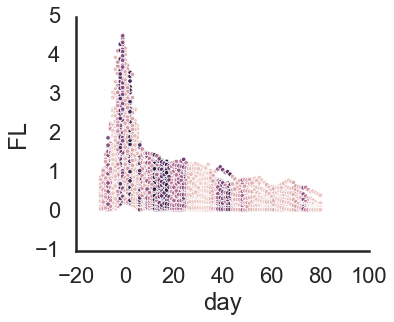

In [104]:
feature_importances1 = pd.DataFrame(clf1.feature_importances_,
                                   index = features1,
                                    columns=['importance'])
merge1df = ds56.merge(feature_importances1, left_on='day', right_index=True, how='left')
sns.relplot(data=merge1df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)

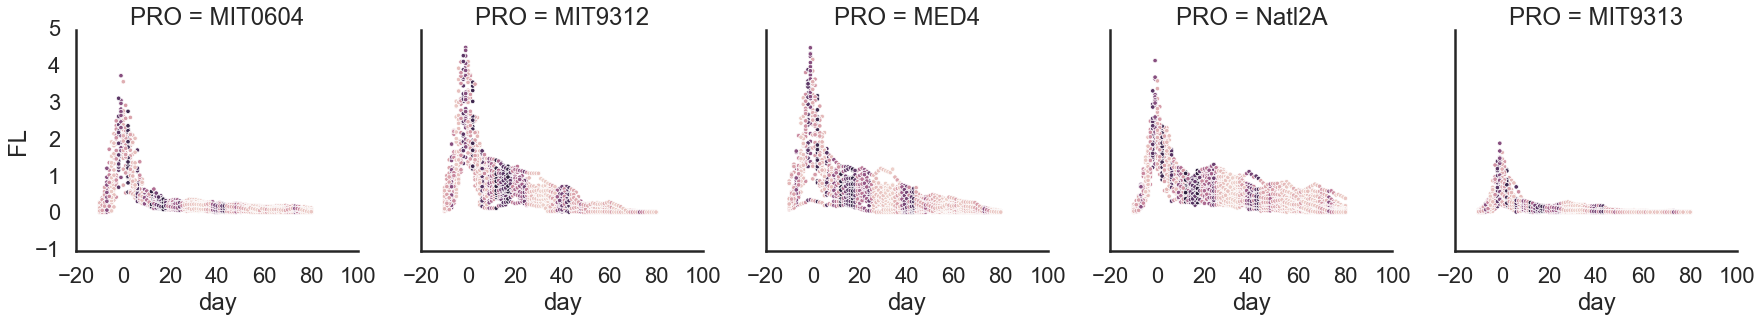

In [105]:
sns.relplot(data=merge1df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

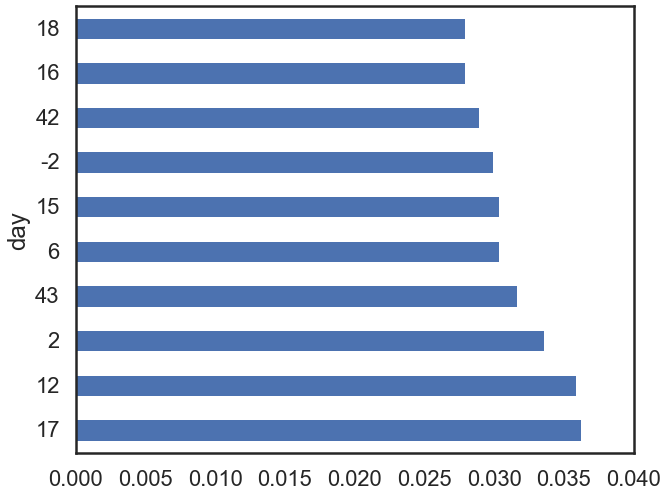

In [106]:
feature_importances1.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [107]:
feature_importances_all34 = pd.DataFrame({
    'day': [v for l in features34_list for v in l],
    'importance' :  [v for l in clf34_list for v in l.feature_importances_ ]
})
feature_importances_all56 = pd.DataFrame({
    'day': [v for l in features56_list for v in l],
    'importance' :  [v for l in clf56_list for v in l.feature_importances_ ]
})
feature_importances_all1 = pd.DataFrame({
    'day': [v for l in features1_list for v in l],
    'importance' :  [v for l in clf1_list for v in l.feature_importances_ ]
})



In [108]:
feature_importances_all34.index

RangeIndex(start=0, stop=2730, step=1)

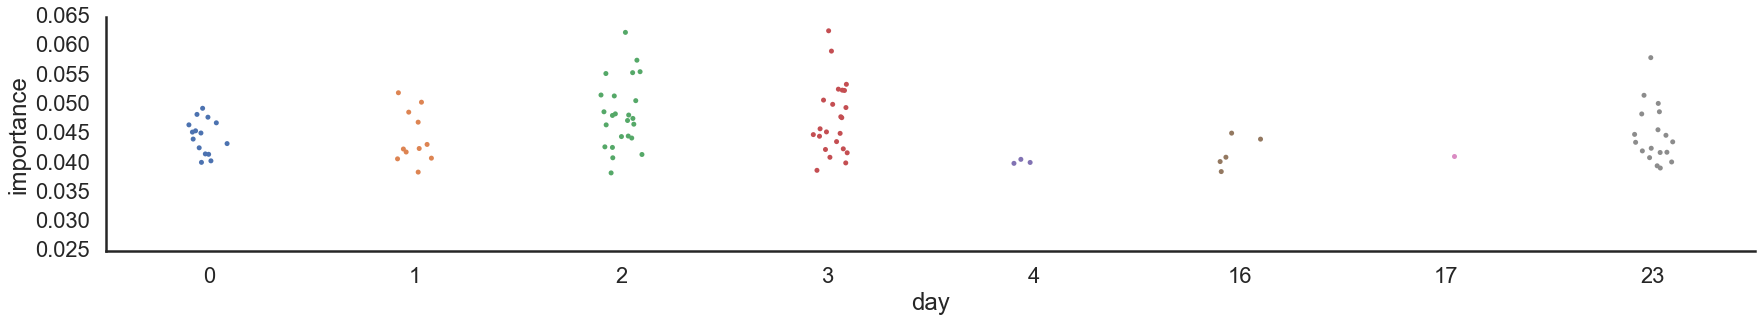

In [111]:
sns.catplot(data=feature_importances_all34.nlargest(columns='importance', n=100), x='day', y='importance',  aspect=5)

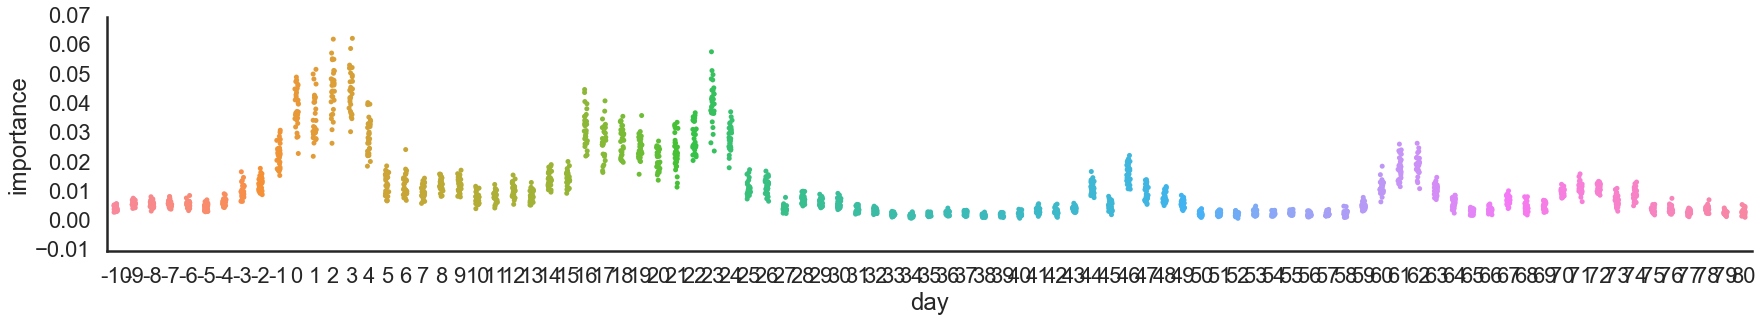

In [112]:
sns.catplot(data=feature_importances_all34, x='day', y='importance',  aspect=5)

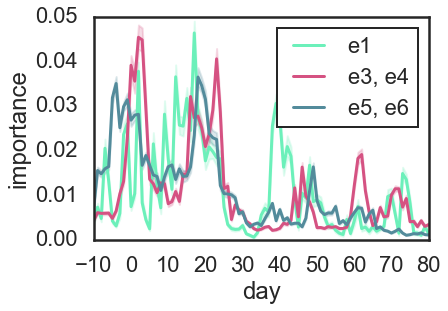

In [228]:
sns.lineplot(data=feature_importances_all1, x='day', y='importance', color=espallete[0],   label='e1', )
sns.lineplot(data=feature_importances_all34, x='day', y='importance', color=espallete[1], label='e3, e4')
sns.lineplot(data=feature_importances_all56, x='day', y='importance', color=espallete[2],  label='e5, e6')


# cluster by decline

## PCA 5 experiments

In [117]:
value_col = 'FL'

In [118]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(ds, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.72765281 0.11741346]


In [119]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

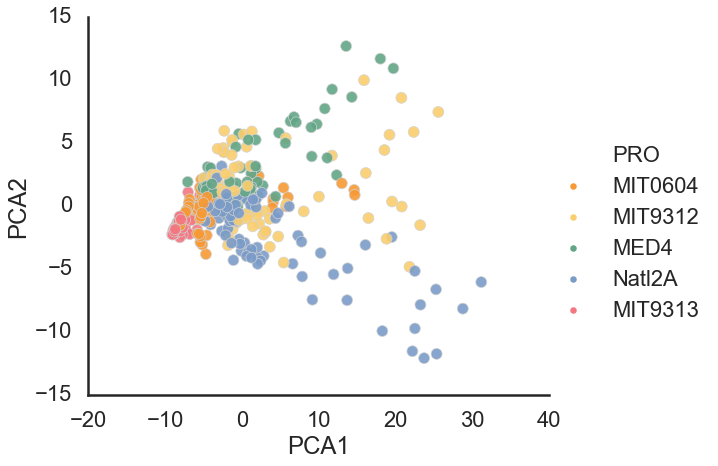

In [120]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

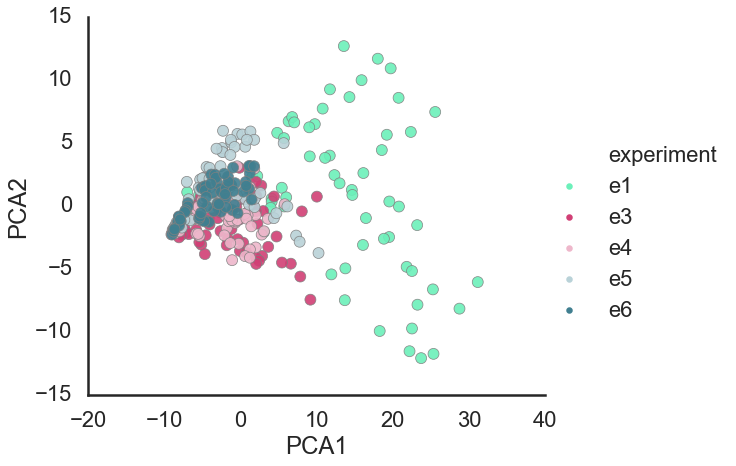

In [121]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

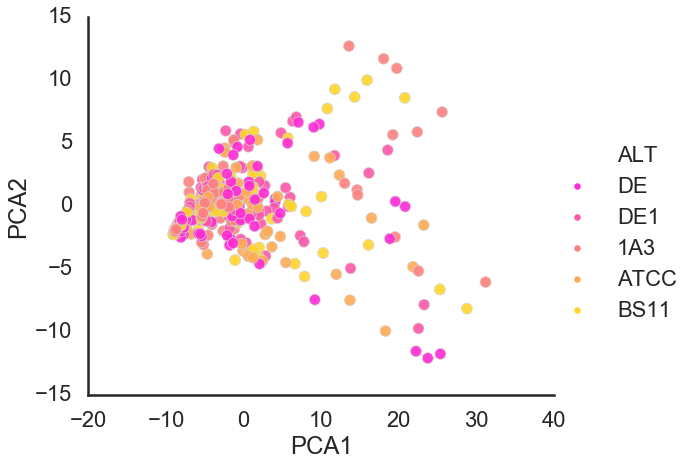

In [122]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

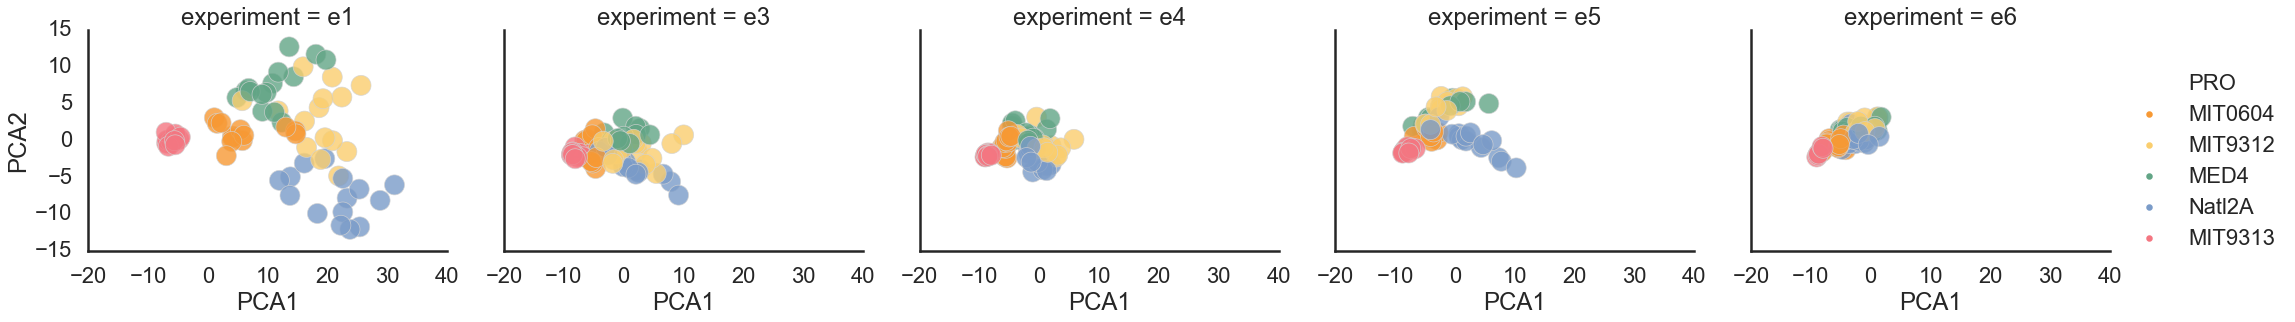

In [123]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

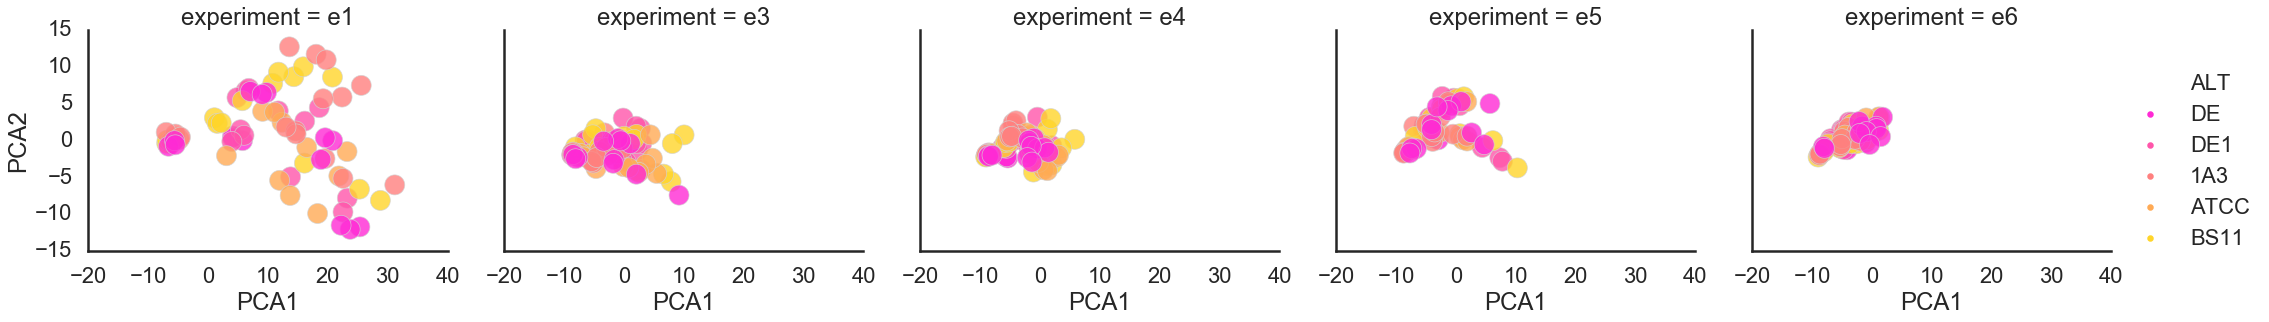

In [124]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

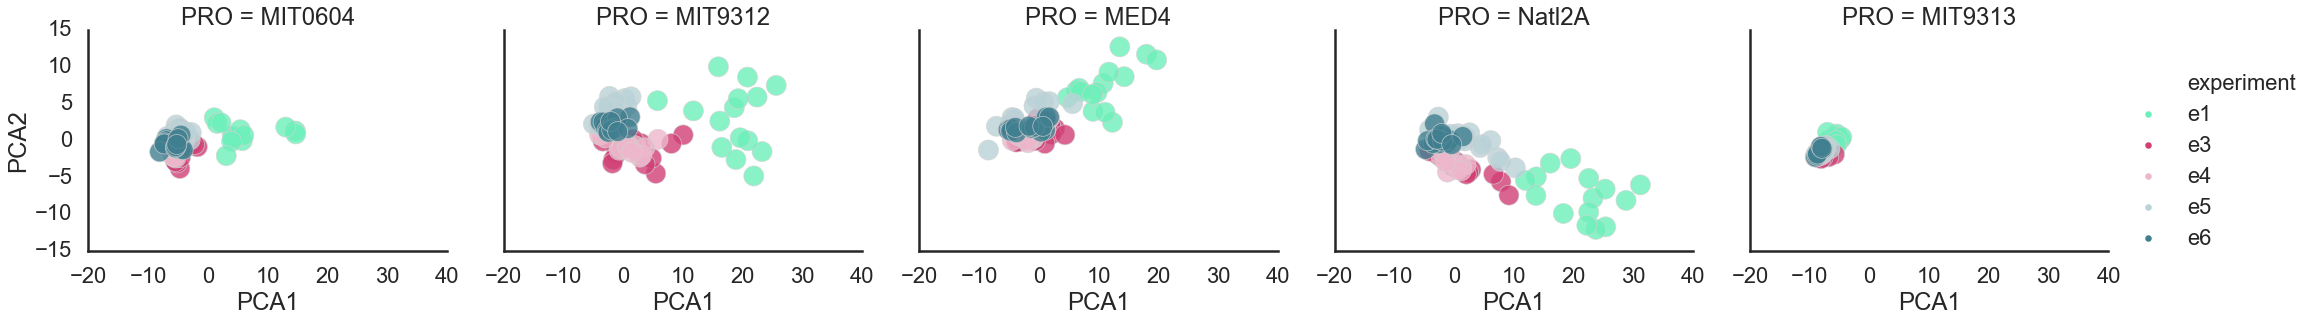

In [125]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [214]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(ds, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

In [215]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

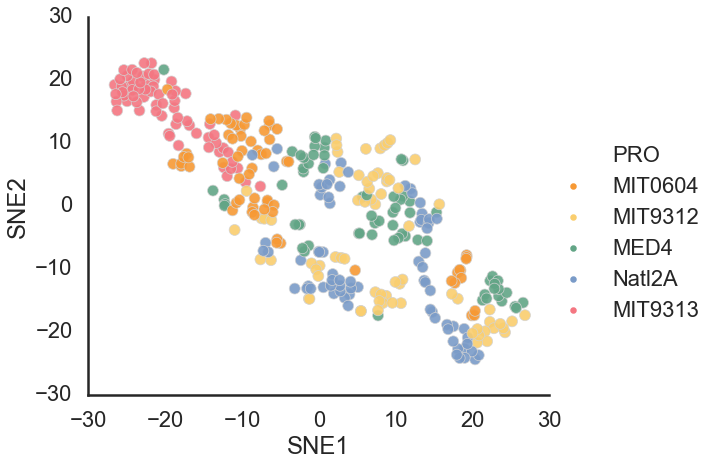

In [216]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

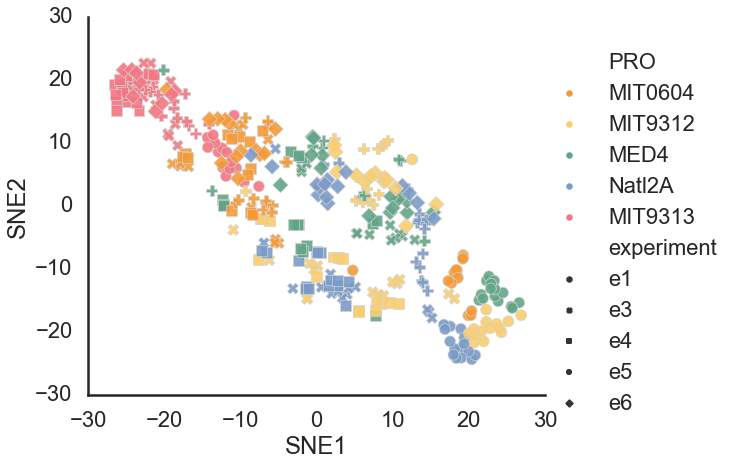

In [226]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            style='experiment',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

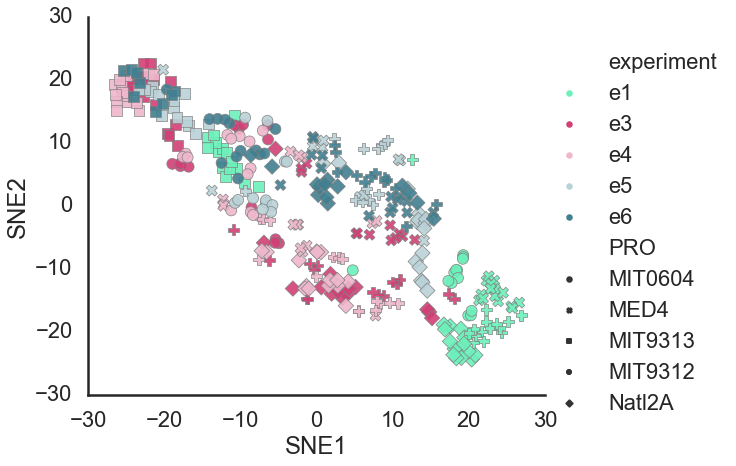

In [225]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            style='PRO',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

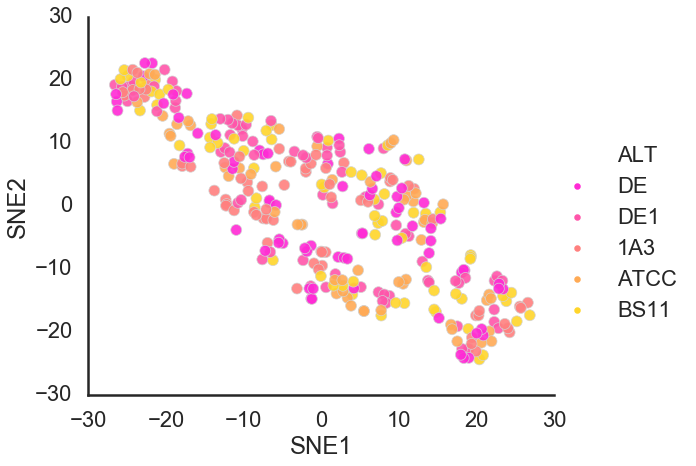

In [219]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

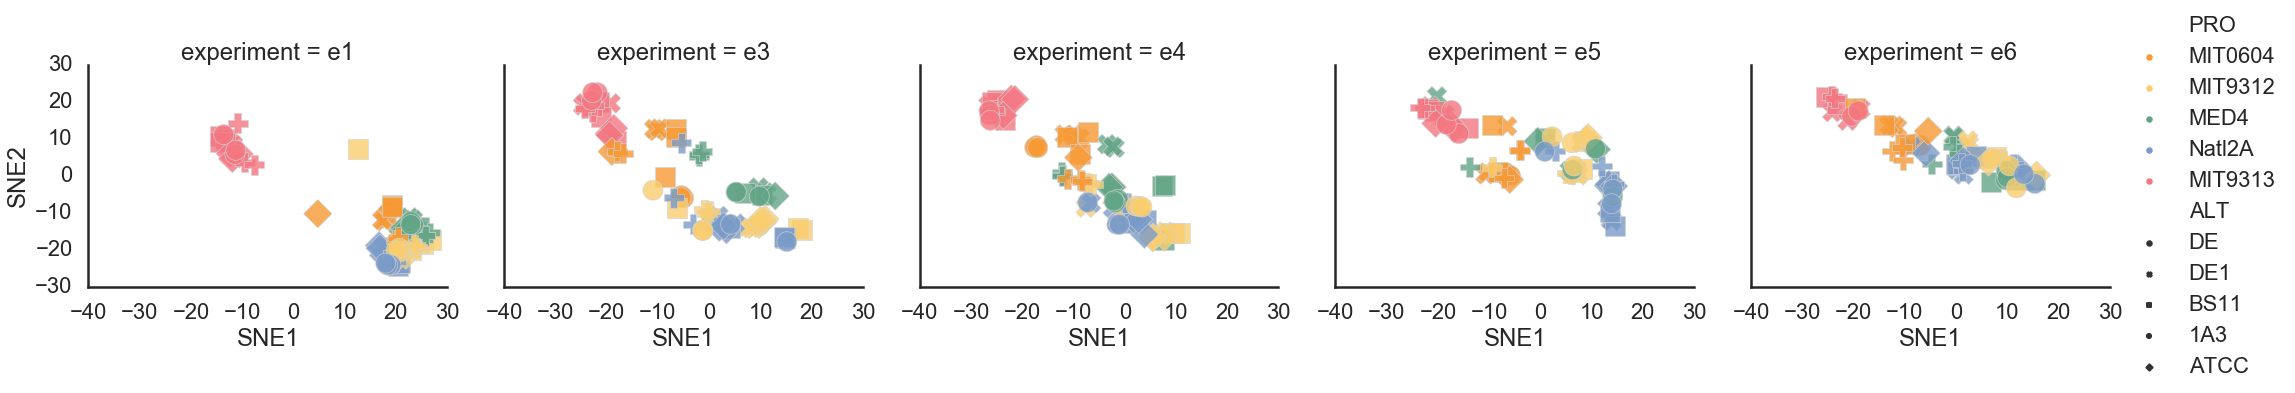

In [224]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

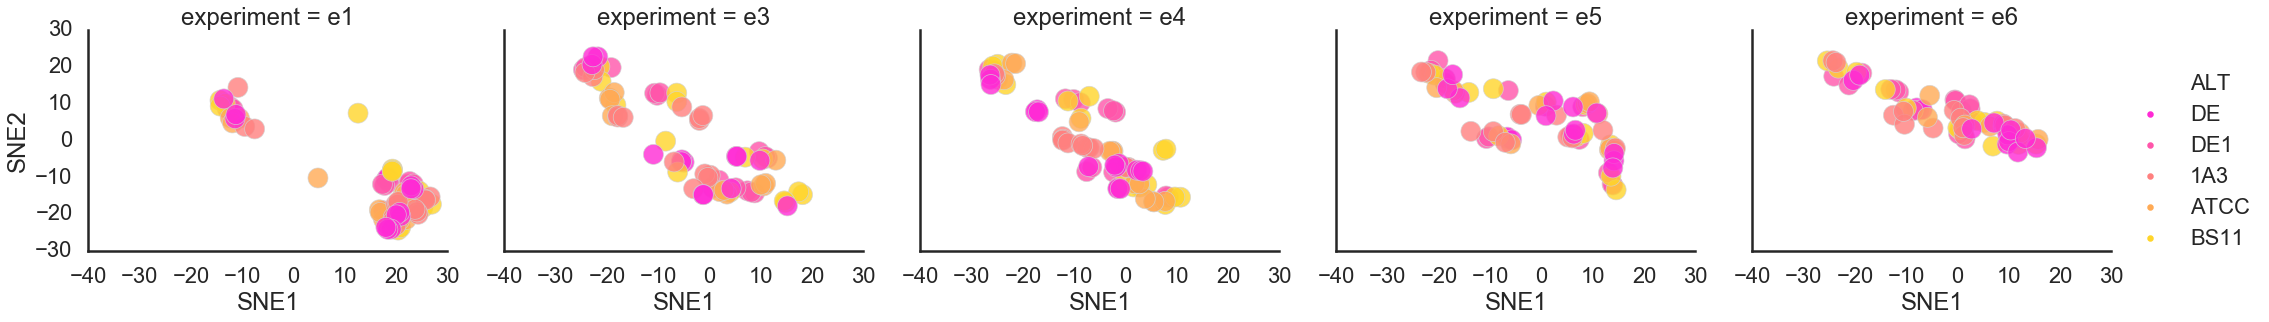

In [221]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

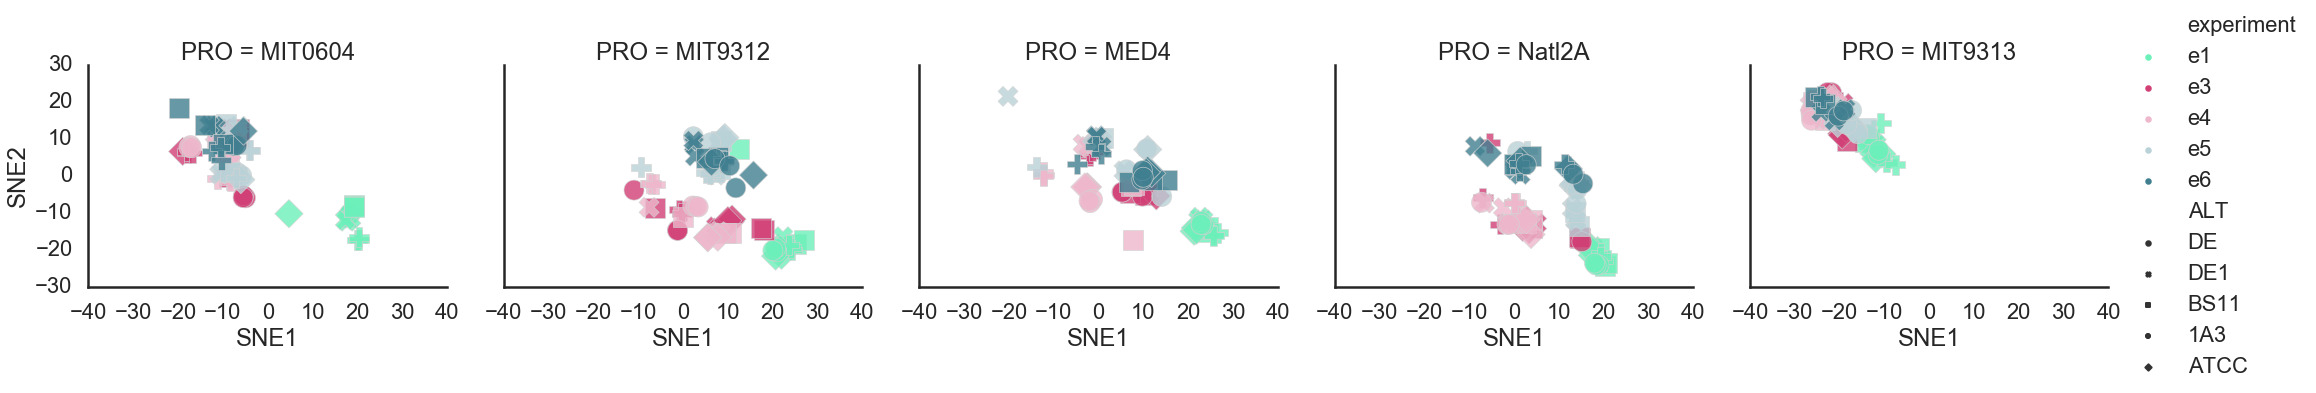

In [223]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

## PCA 4 experiments

In [156]:
value_col = 'FL'

In [157]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4', 'e5', 'e6'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.56457792 0.1723785 ]


In [158]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

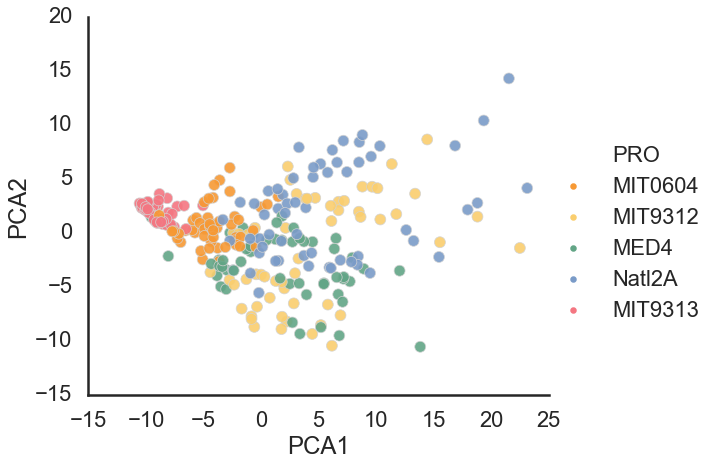

In [159]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

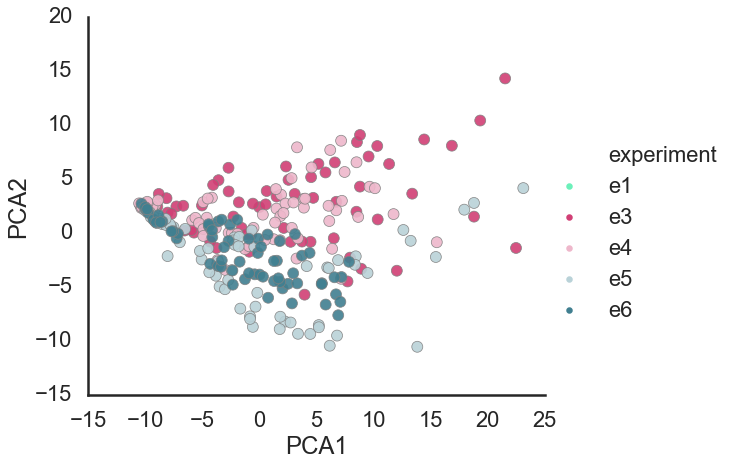

In [160]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

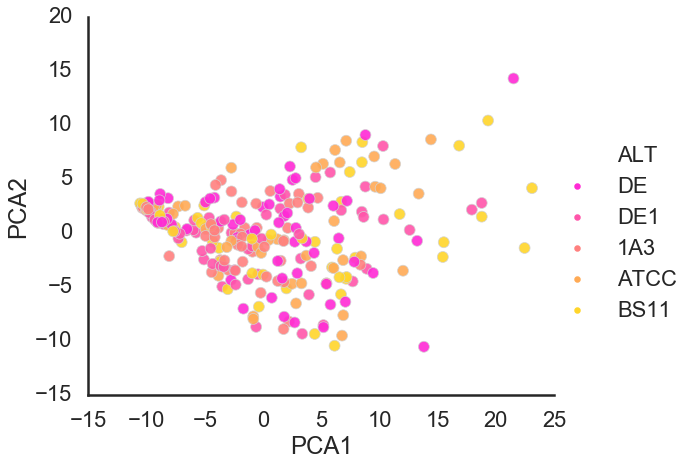

In [161]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

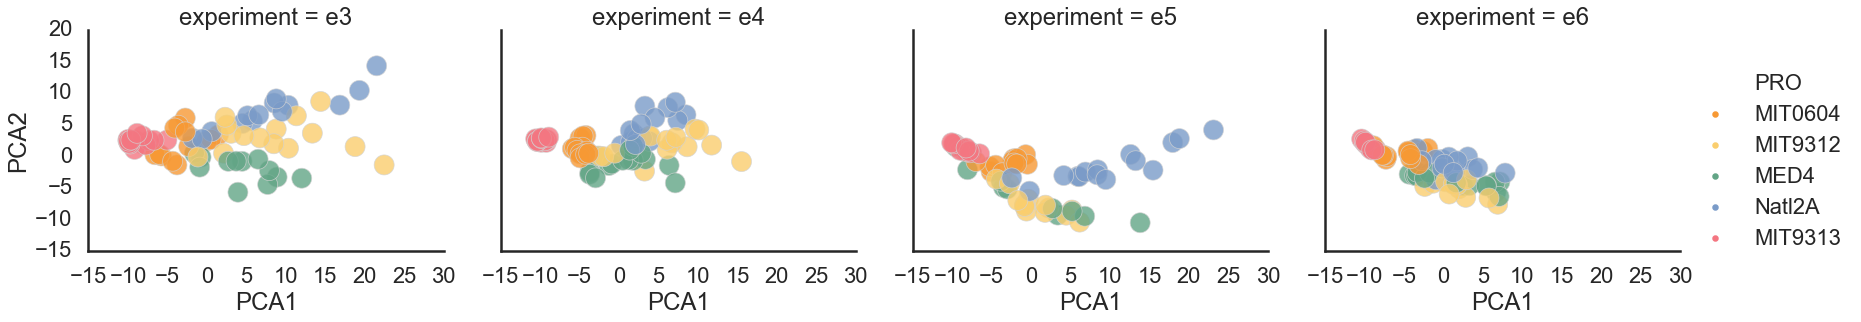

In [162]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

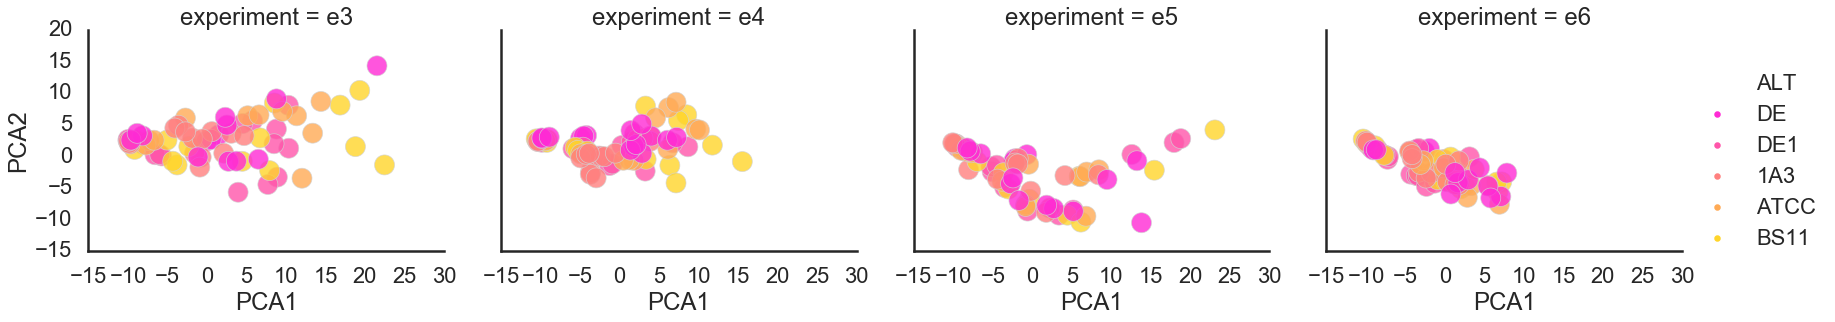

In [163]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

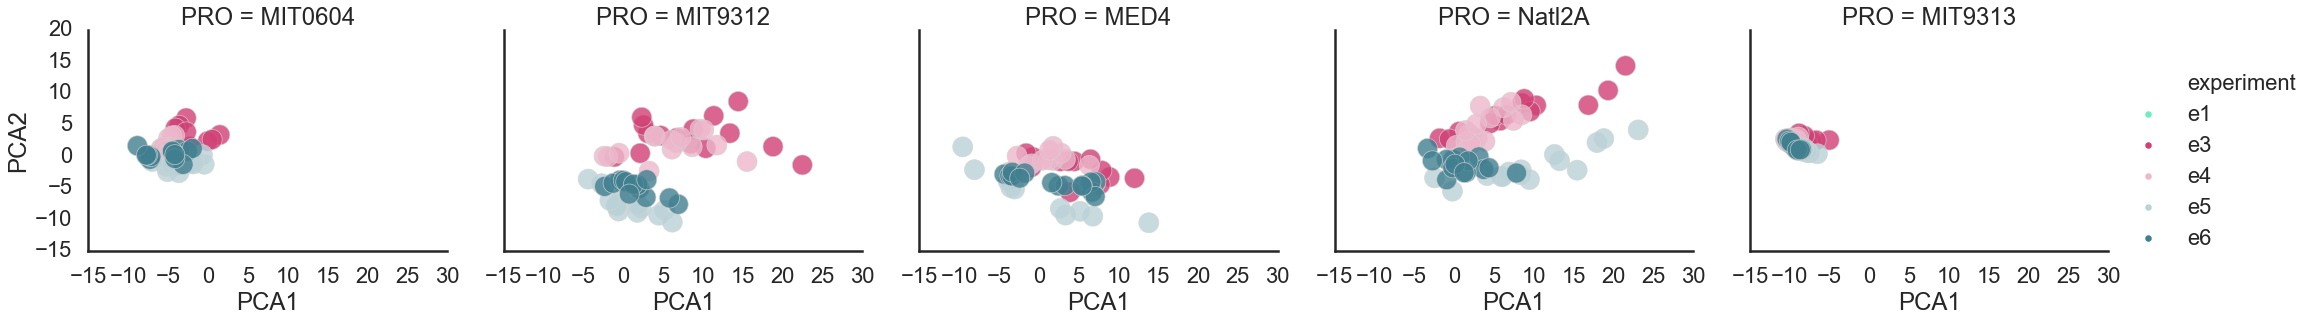

In [164]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [165]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4', 'e5', 'e6'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

In [166]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

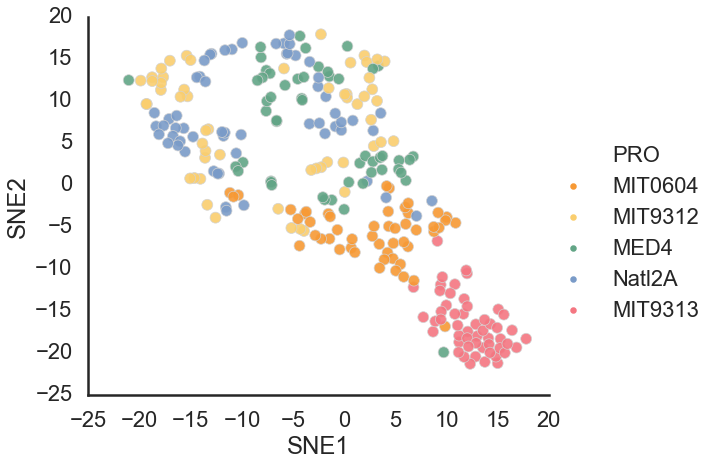

In [167]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

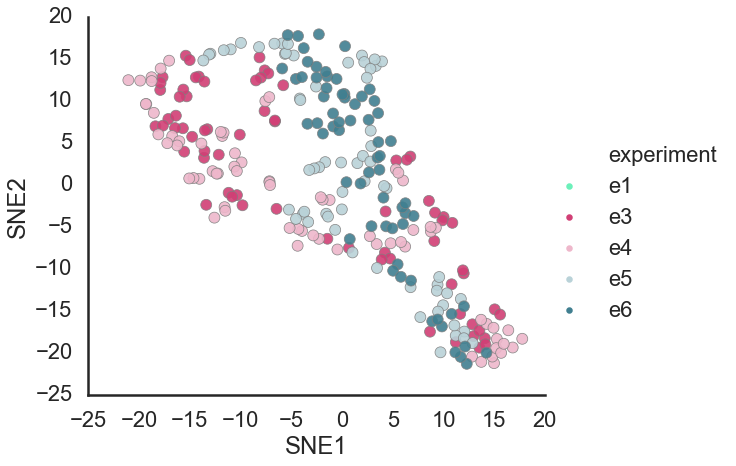

In [168]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

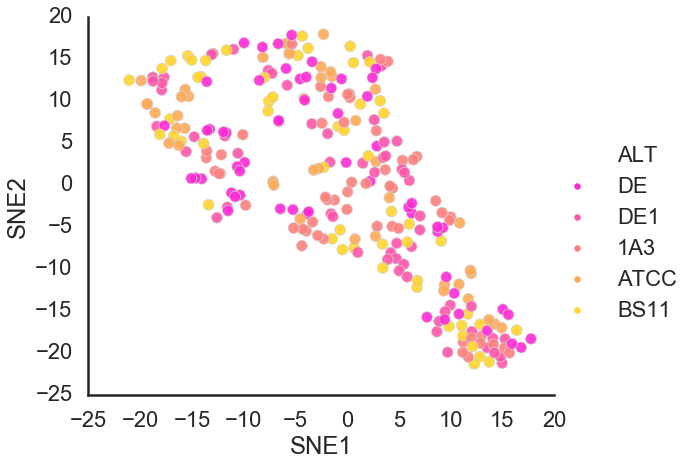

In [169]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

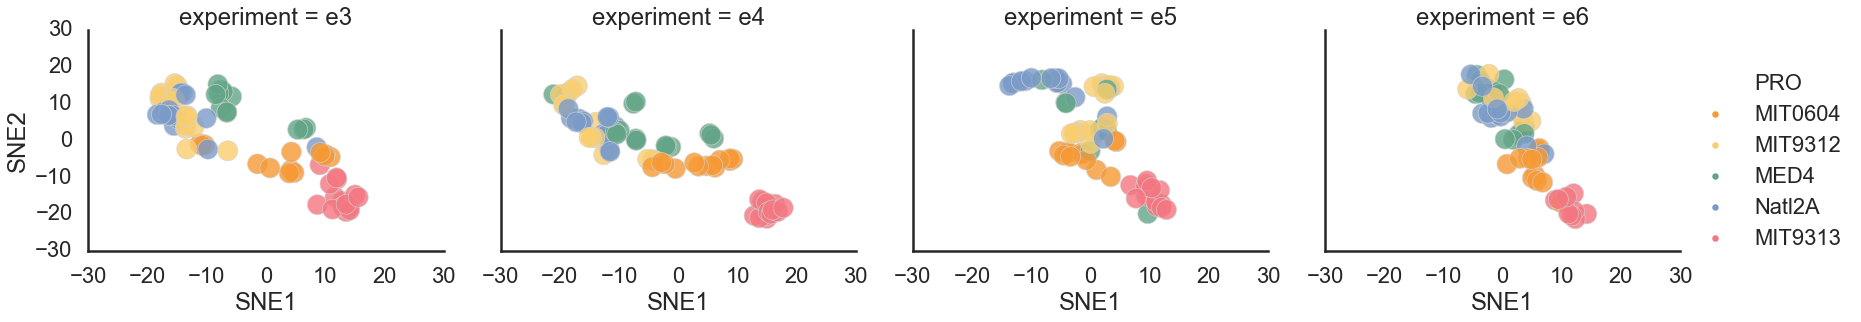

In [170]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

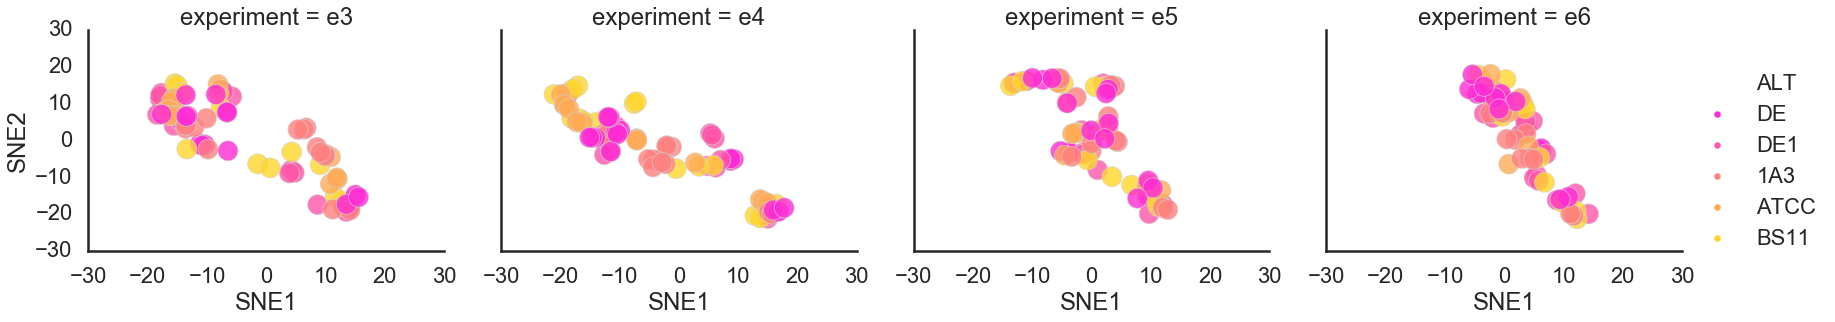

In [171]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

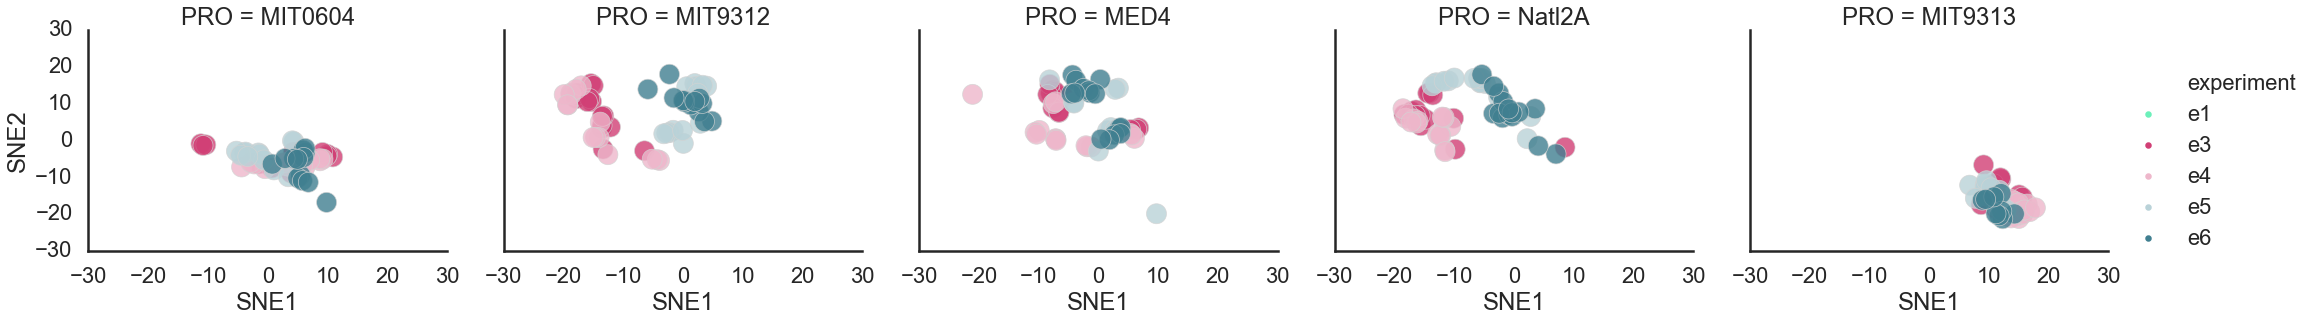

In [172]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

## PCA 3,4 experiments

In [173]:
value_col = 'FL'

In [174]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.62707758 0.1001848 ]


In [175]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

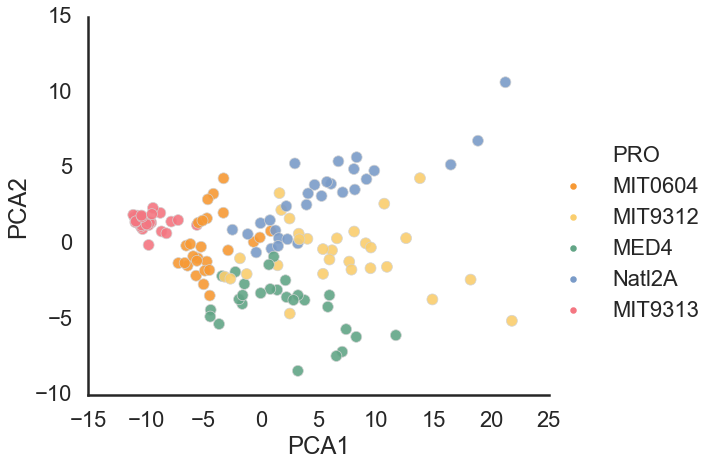

In [176]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

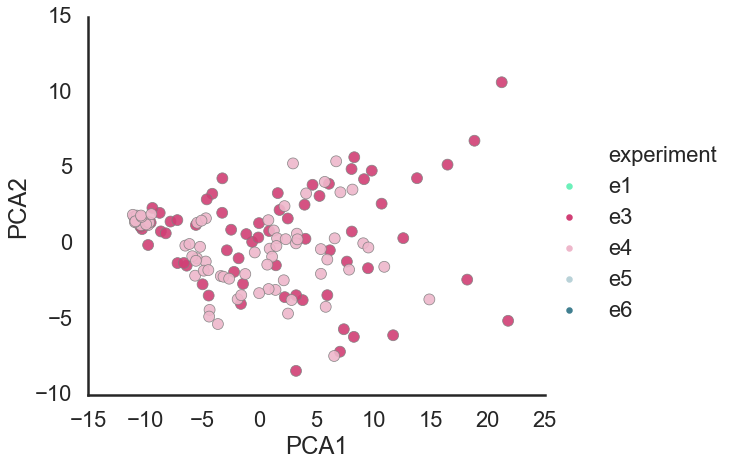

In [177]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

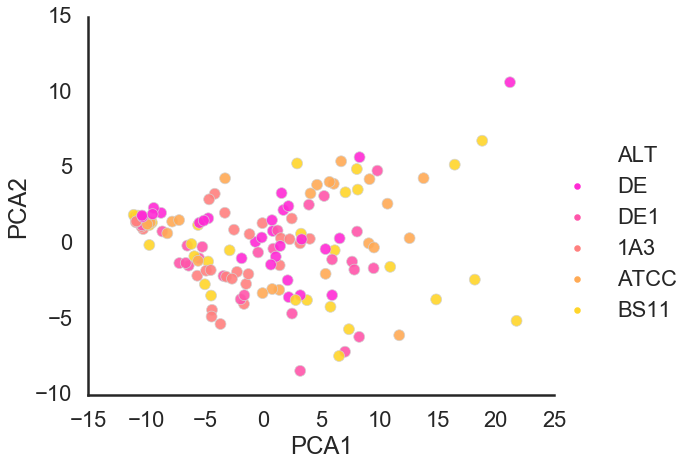

In [178]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

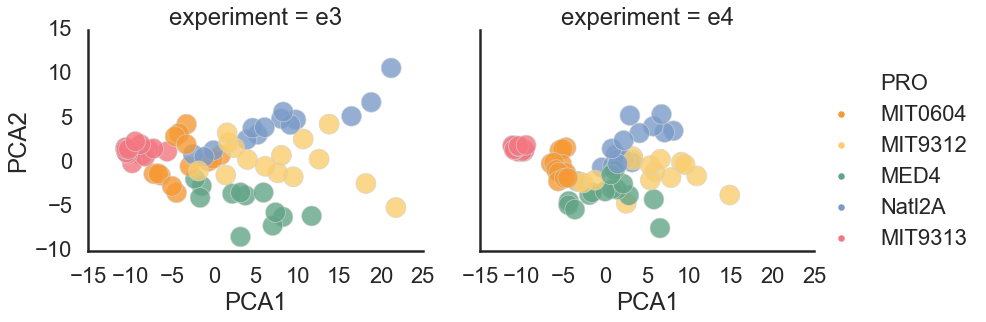

In [179]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

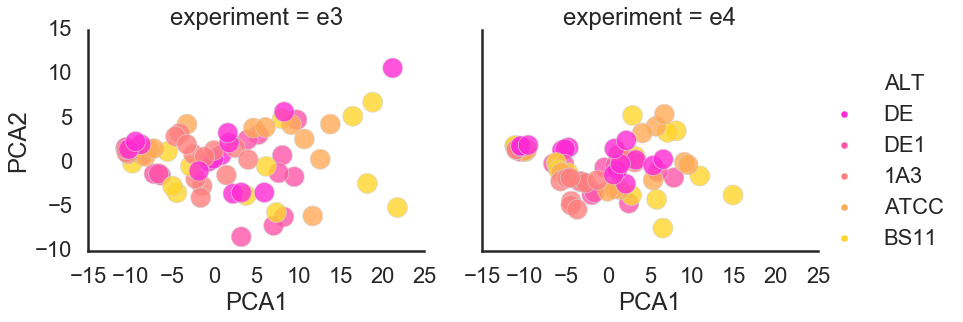

In [180]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

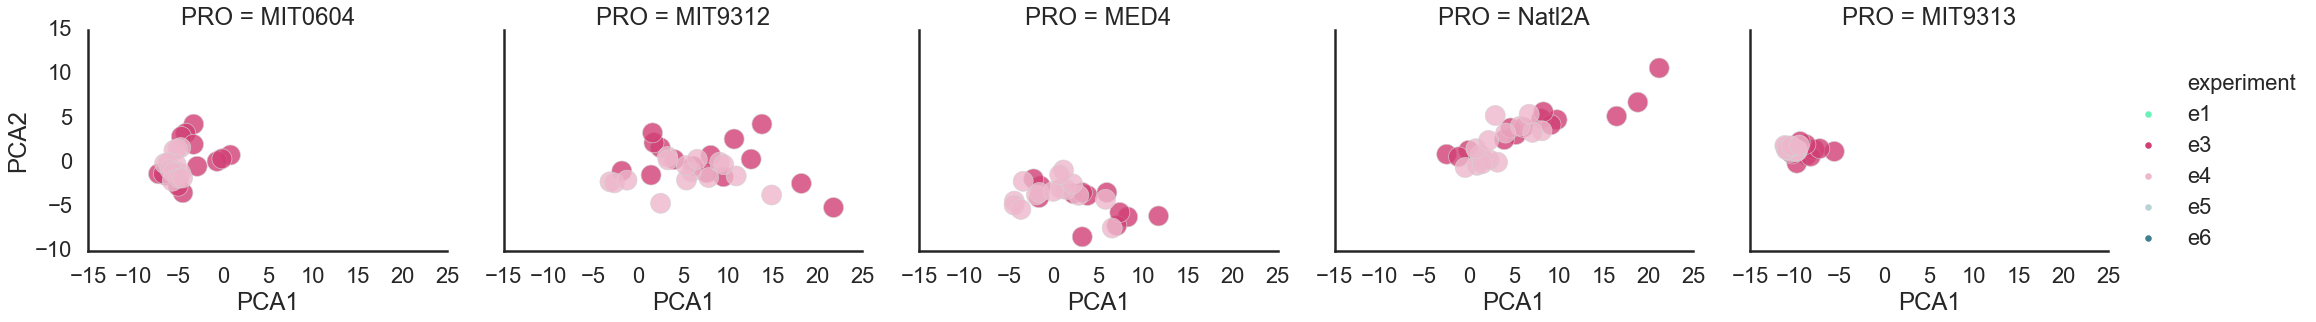

In [181]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [182]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

In [183]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

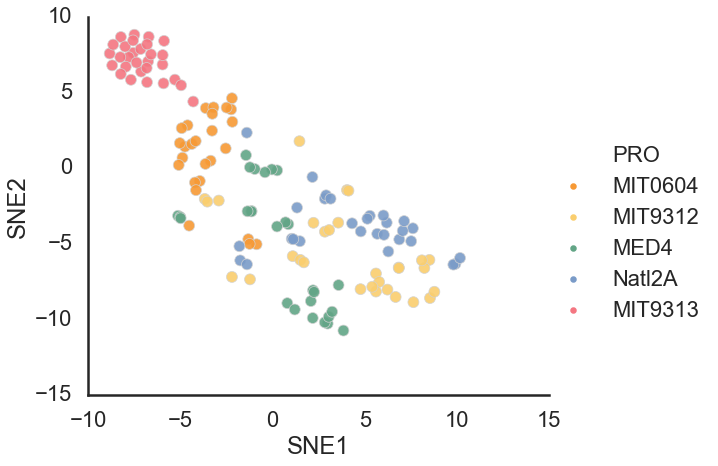

In [184]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

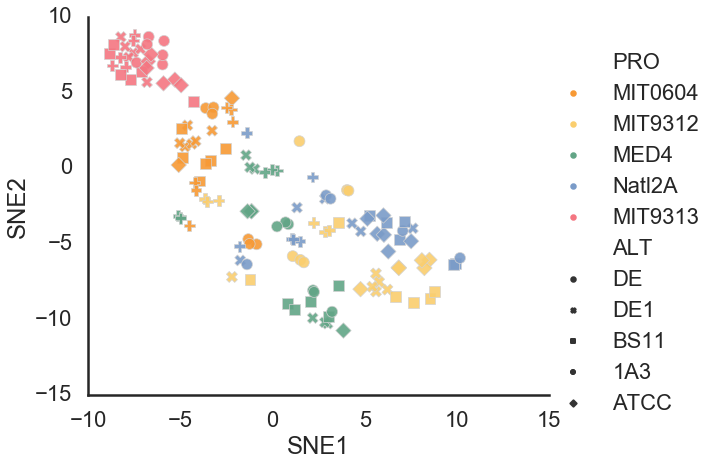

In [190]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            style='ALT',
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

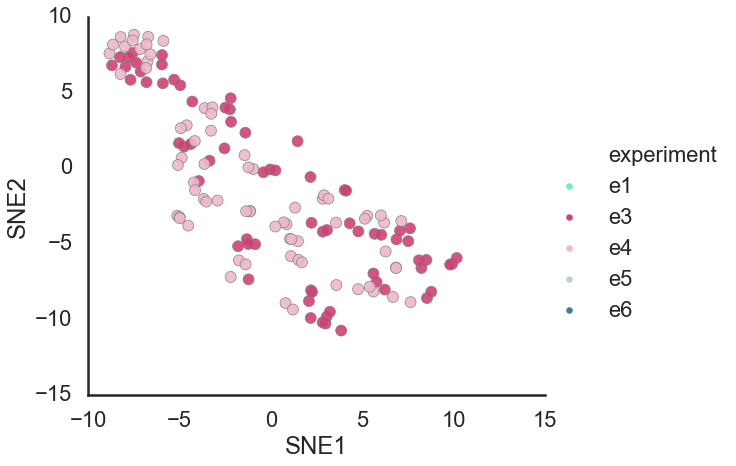

In [185]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

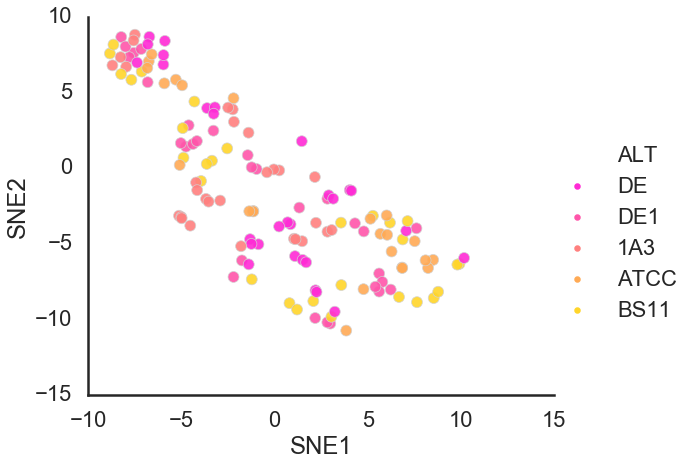

In [186]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

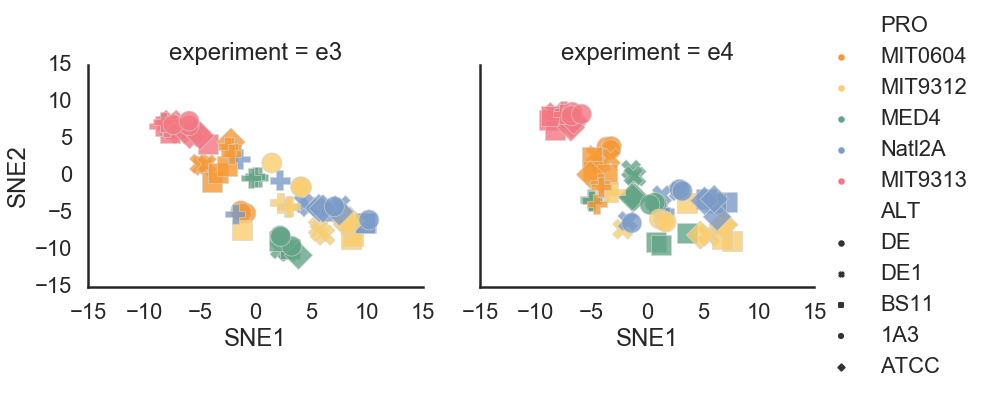

In [194]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

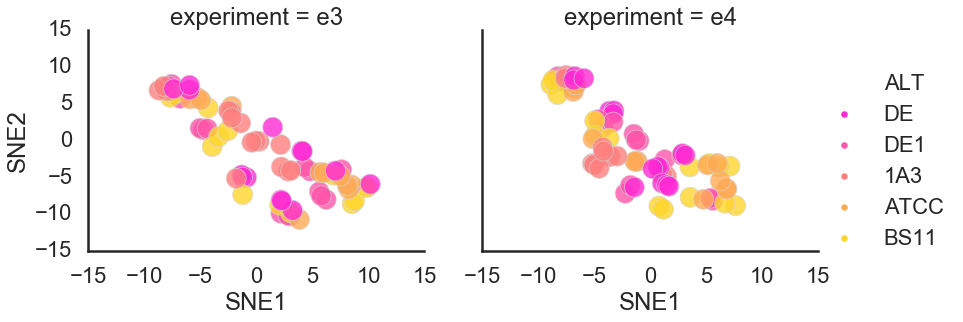

In [188]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

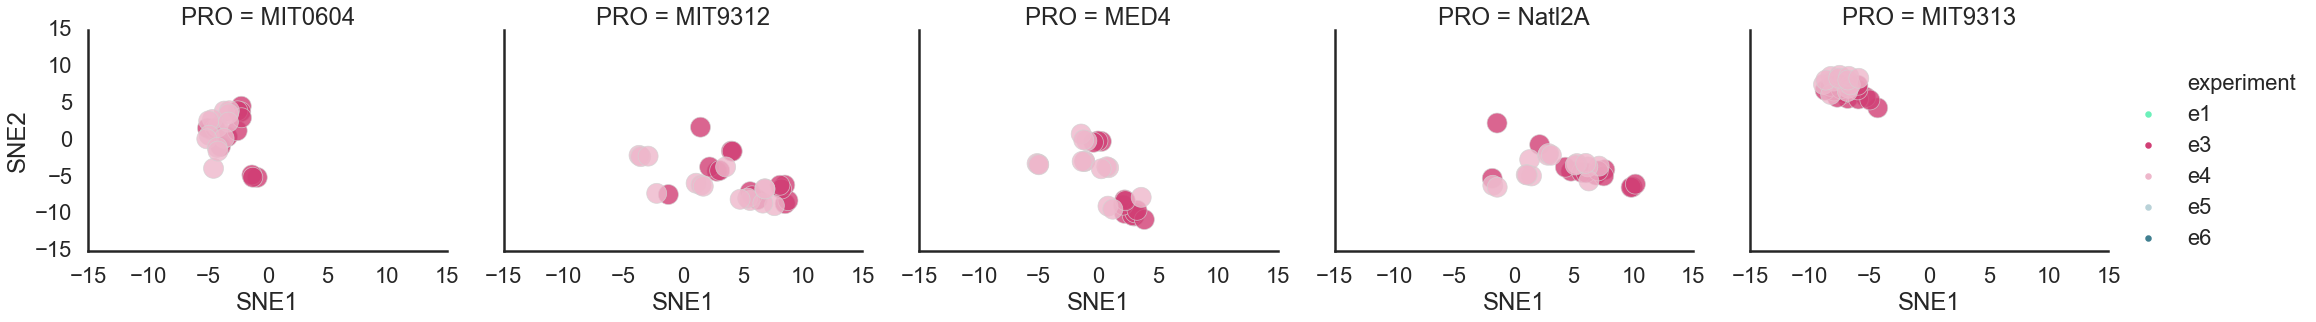

In [189]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

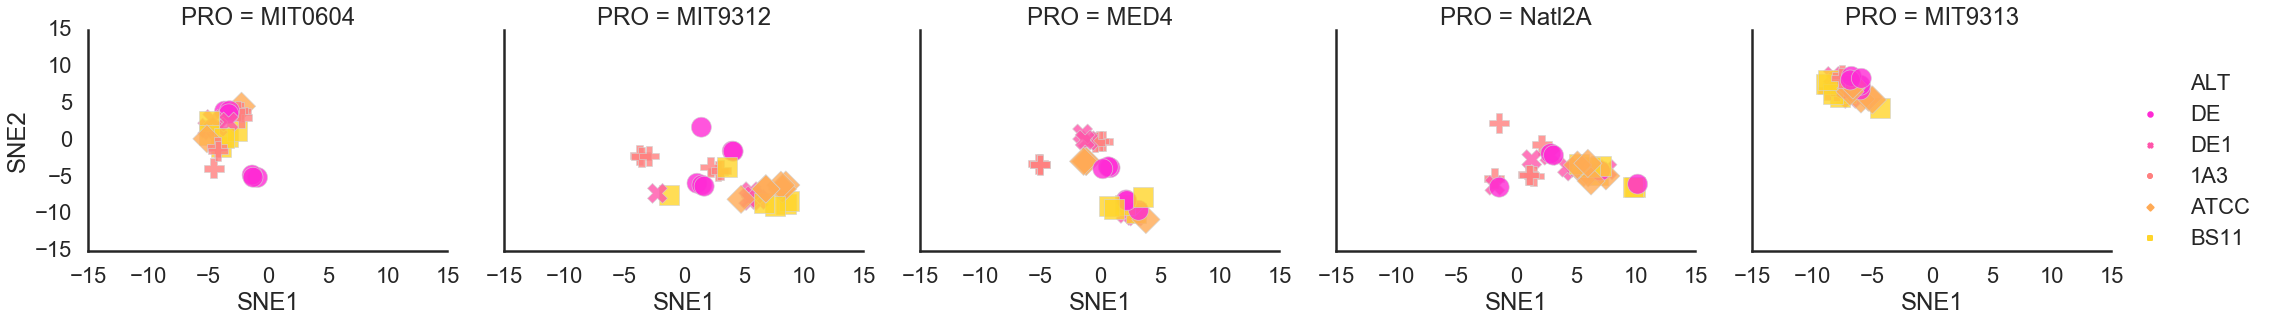

In [193]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='ALT',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

# PCA 1 experiments

In [195]:
value_col = 'FL'

In [196]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
pcain_df = ds.loc[ds.experiment.isin(['e1'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.66265771 0.17907911]


In [197]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

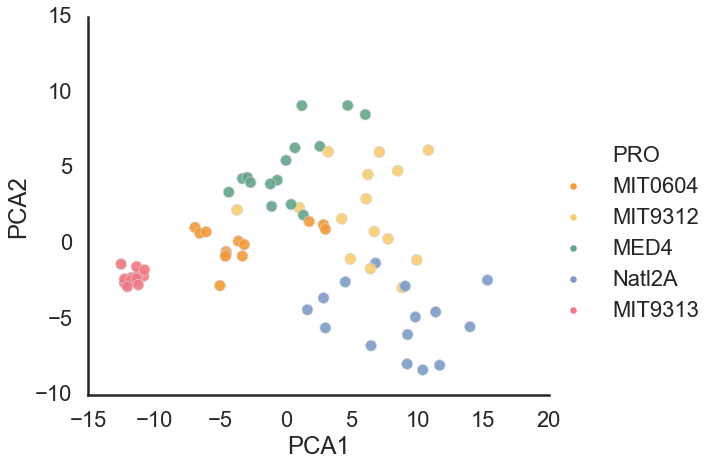

In [198]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

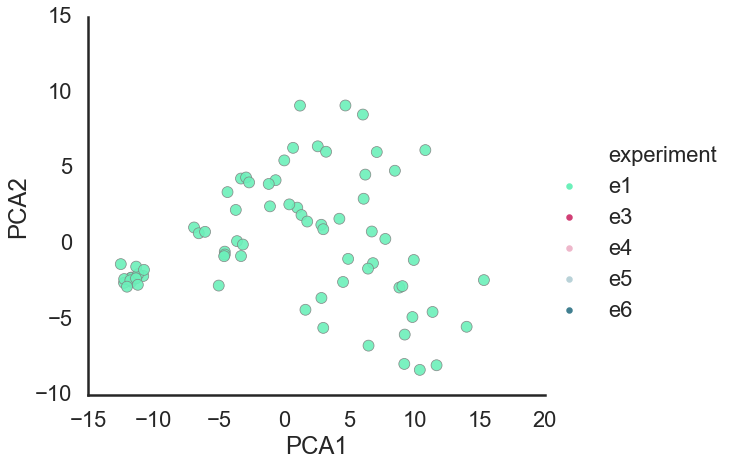

In [199]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

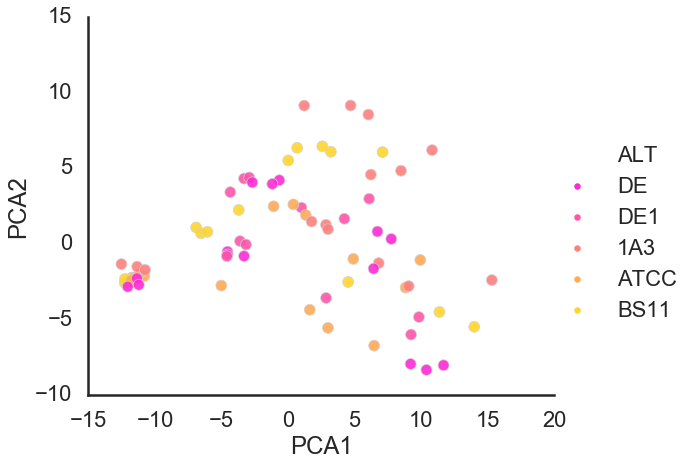

In [200]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

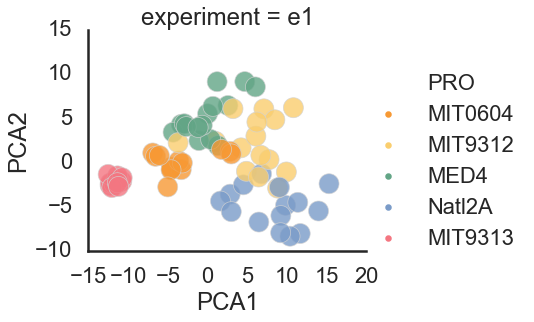

In [201]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

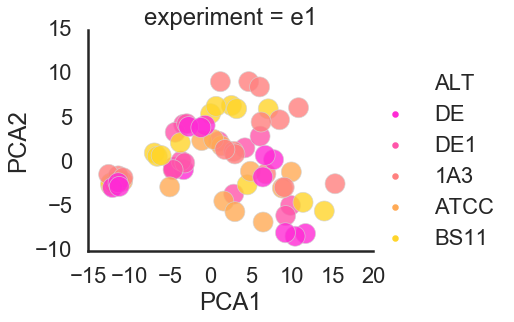

In [202]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

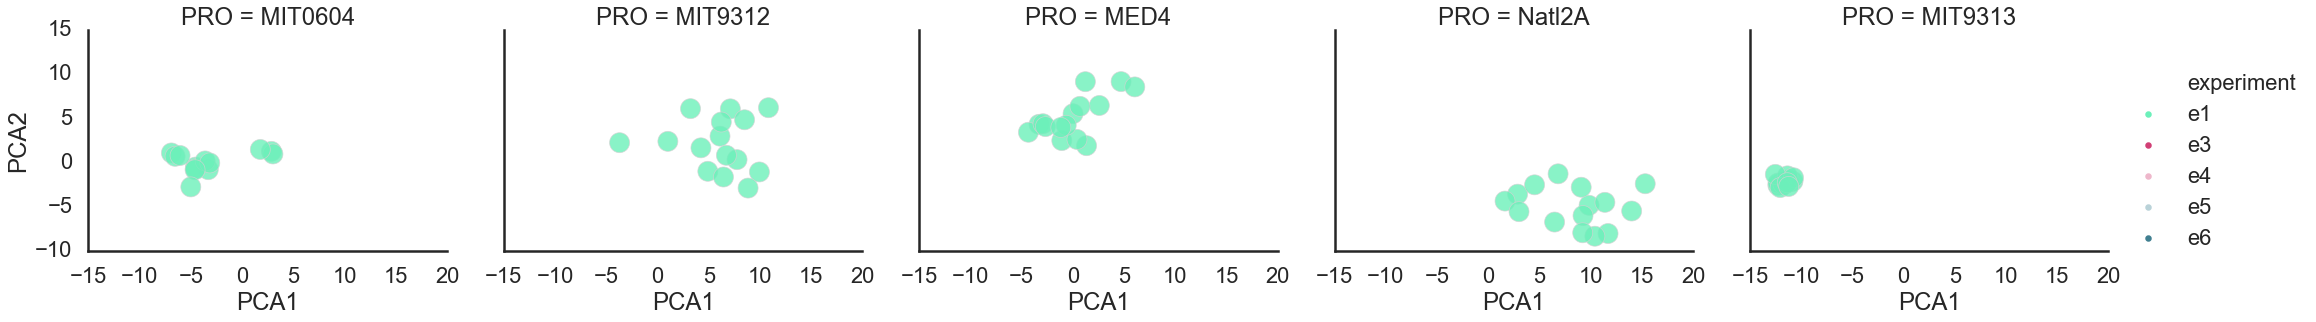

In [203]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [204]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
pcain_df = ds.loc[ds.experiment.isin(['e1'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

In [205]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

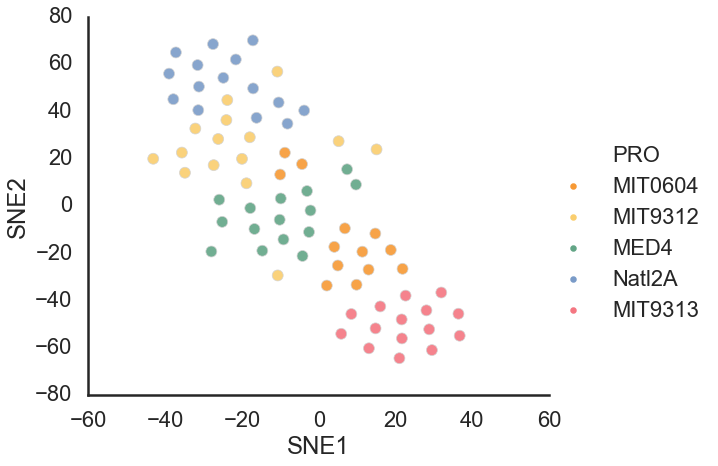

In [206]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

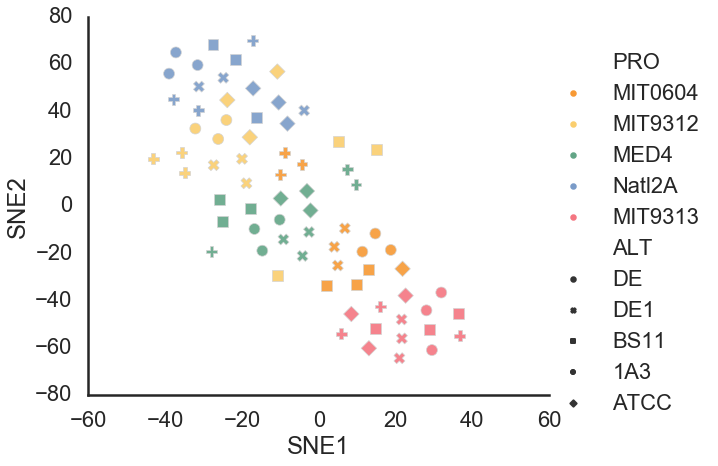

In [207]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            style='ALT',
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

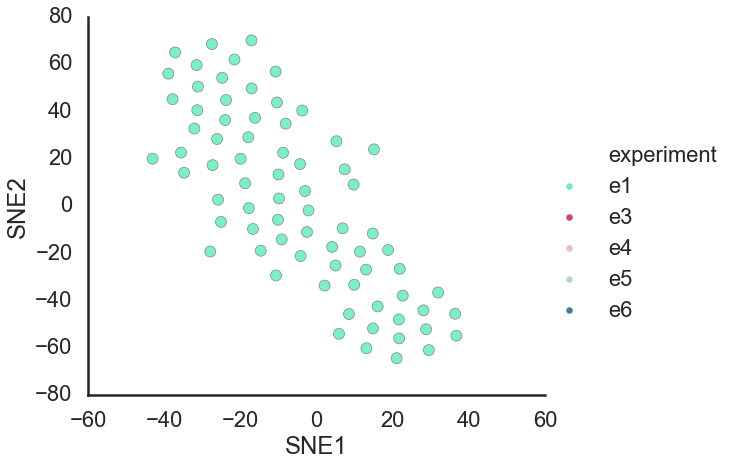

In [208]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

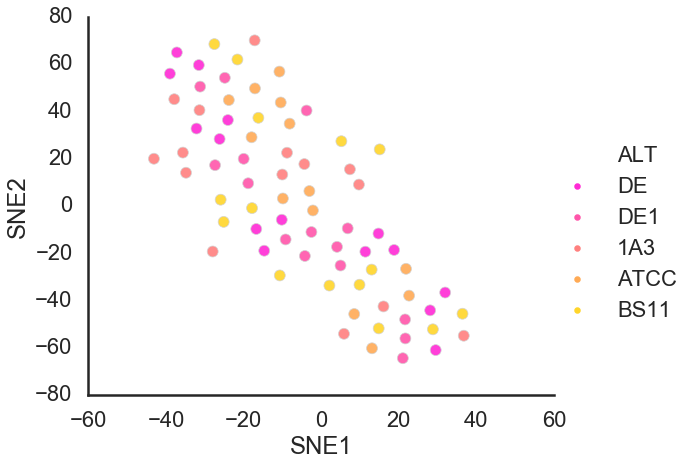

In [209]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

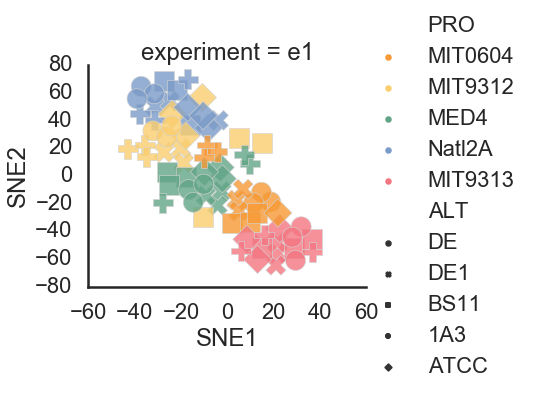

In [210]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

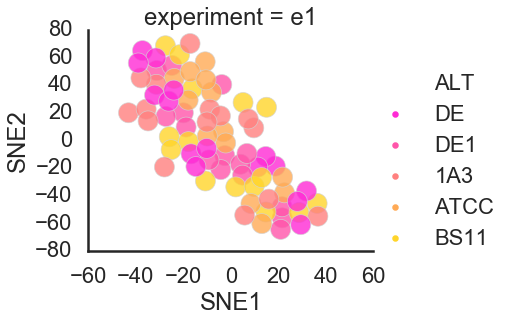

In [211]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

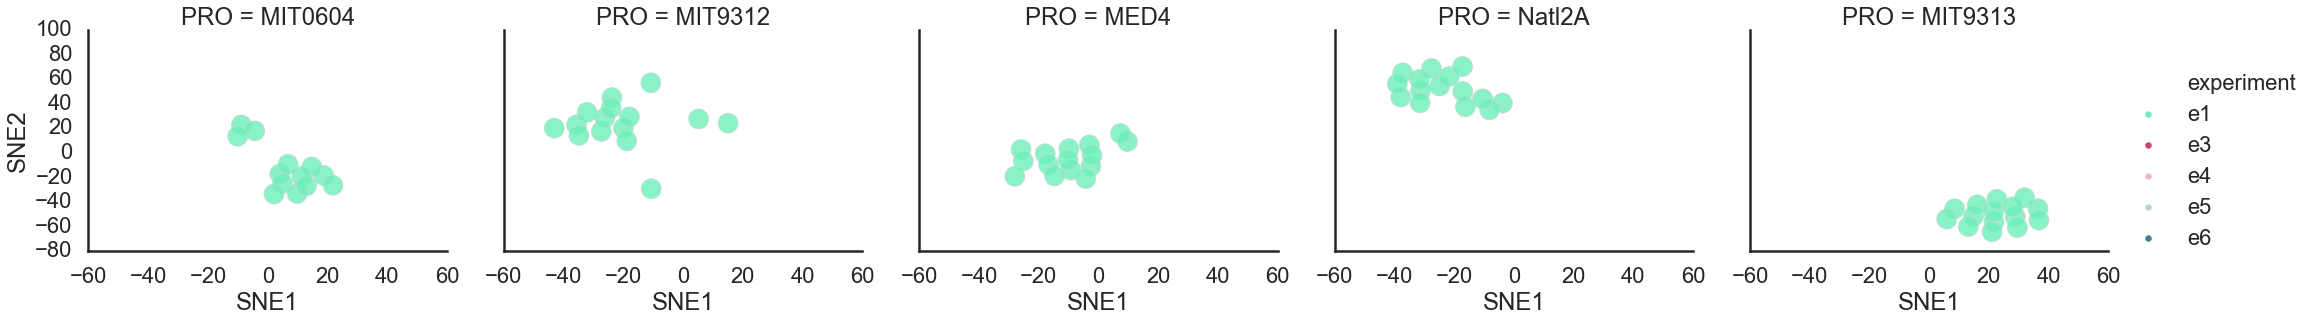

In [212]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

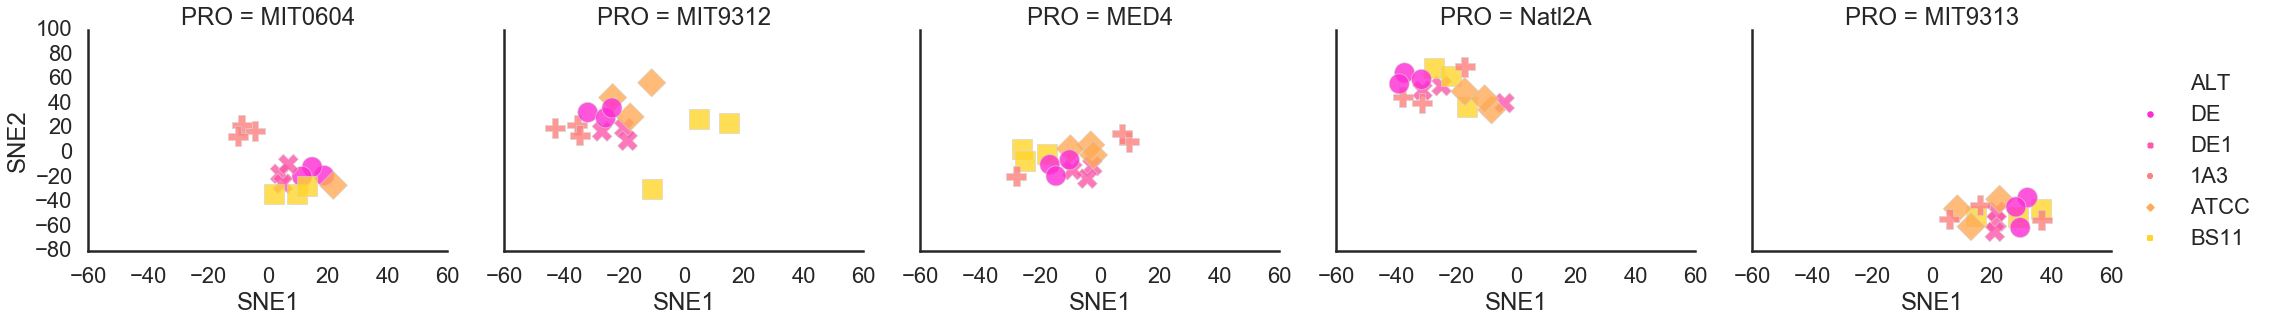

In [213]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='ALT',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

# Heatmaps

In [126]:
#metadf = cp.get_meta(df, meta_col=['experiment_sample', 'Mode','Sample', 'PRO', 'ALT'])
#metadf = metadf.loc[metadf.experiment_sample.isin(X1.index)]
metadf.index = metadf[sample_col]
col = 'PRO'
lut = dict(zip(metadf[col].unique(), sns.color_palette('Set2', n_colors=metadf[col].nunique())))
lut = dict(zip(porder, sns.color_palette(ppallete, n_colors=metadf[col].nunique())))
row_colors = metadf[col].map(lut)

col2 = 'experiment'
lut2 = dict(zip(metadf[col2].unique(), sns.color_palette('Set3', n_colors=metadf[col2].nunique())))
lut2 = dict(zip(eorder, sns.color_palette(epallete, n_colors=metadf[col2].nunique())))
row_colors2 = metadf[col2].map(lut2)

col3 = 'ALT'
lut3 = dict(zip(aorder, sns.color_palette(apallete, n_colors=metadf[col3].nunique())))
row_colors3 = metadf[col3].map(lut3)

#dfe_resample3 = cp.resample_df(dfe, value_col='decline', period='3d')
#X = cp.experiments2X(dfe_resample3, value_col='decline', cumsummode=False)


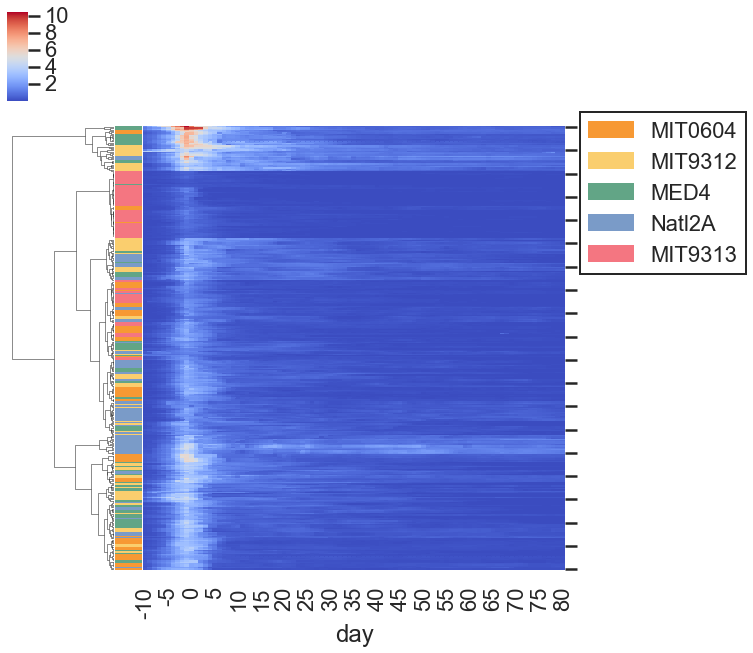

In [127]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

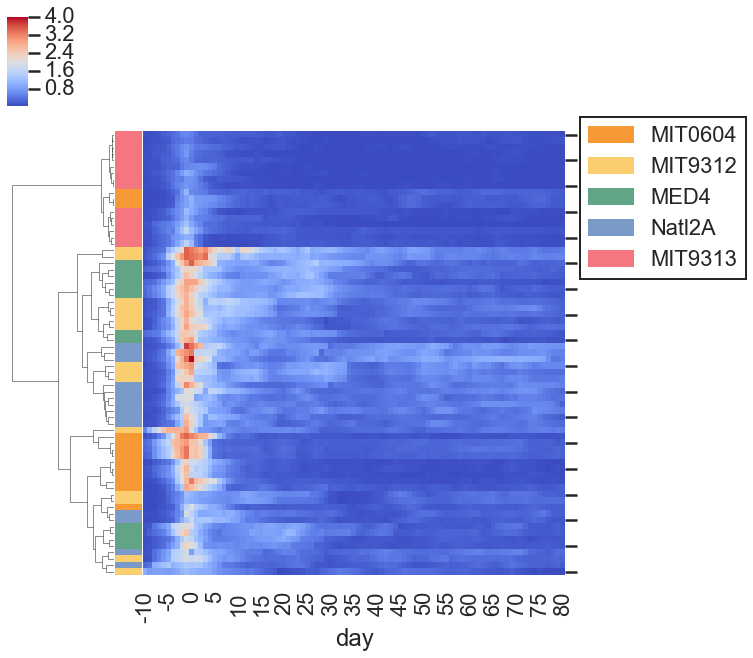

In [60]:
import matplotlib.patches as mpatches
X = cp.experiments2X(ds.loc[ds.experiment == 'e3'], value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds.loc[ds.experiment == 'e3'])
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']

g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                      # row_colors3
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut3.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

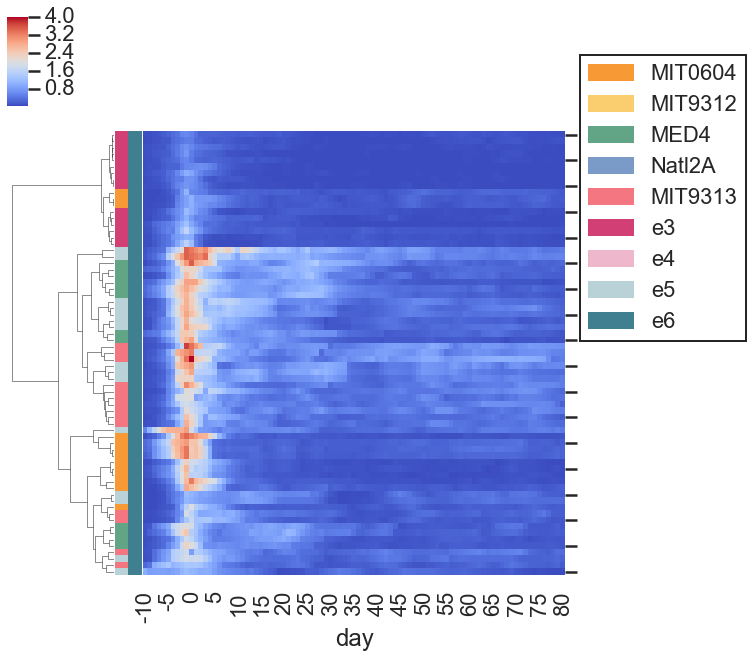

In [61]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

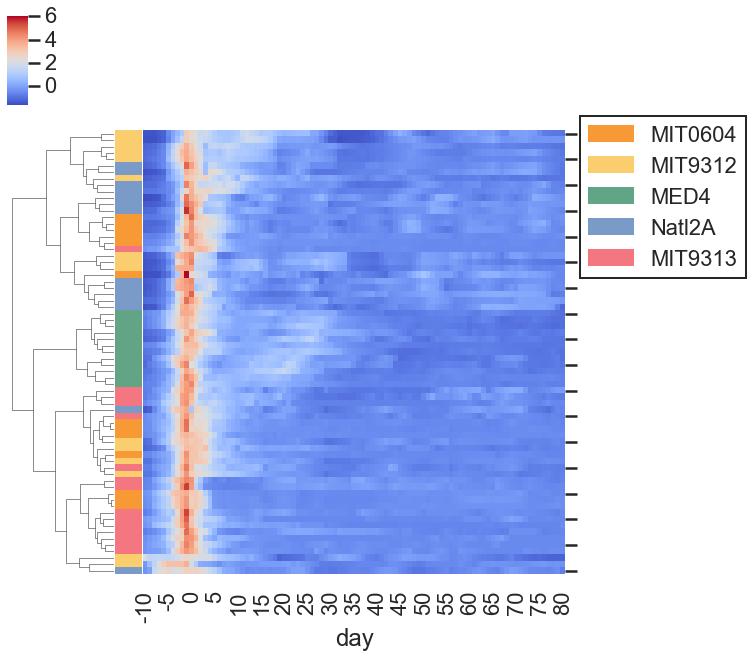

In [62]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward',
                   z_score=0, 
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

# Analyze Features

In [57]:
from sklearn.linear_model import LogisticRegression


In [58]:
import tsfresh
from tsfresh.utilities.dataframe_functions import impute


In [59]:
def compute_corr(x, y):
    x = x.values.reshape(-1, 1)
    clf = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(x, y)
    return clf.score(x,y)

In [ ]:
ds34c = cp.update_calculated_fields(ds34, group_col='experiment_sample', add_experiment_sample=False)
ds56c = cp.update_calculated_fields(ds56, group_col='experiment_sample', add_experiment_sample=False)

df_features34 = cp.generate_features(ds34c)
df_features56 = cp.generate_features(ds56c)

In [ ]:
X_features34 = cp.features2X(df_features34)
metadf_features34 = cp.get_meta(df_features34, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features34.index = metadf_features34.experiment_sample
y34 = metadf_features34['PRO']

In [ ]:
X_features56 = cp.features2X(df_features56)
metadf_features56 = cp.get_meta(df_features56, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features56.index = metadf_features56.experiment_sample
y56 = metadf_features56['PRO']

In [ ]:
ts_f_features_df34 = tsfresh.extract_features(
    ds34c.loc[:, ['experiment_sample', 'FL', 'logFL', 'cumsumFL', 'cumsumlogFL', 'rateFL', 'ratelogFL', 'day']].fillna(0),
     column_id='experiment_sample', column_kind=None, 
     column_sort='day', 
    )


In [ ]:
ts_f_features_df56 = tsfresh.extract_features(
    ds56c.loc[:, ['experiment_sample', 'FL', 'logFL', 'cumsumFL', 'cumsumlogFL', 'rateFL', 'ratelogFL', 'day']].fillna(0),
     column_id='experiment_sample', column_kind=None, 
     column_sort='day', 
    )


In [ ]:
ts_f_features_df34 = impute(ts_f_features_df34)
ts_f_features_df56 = impute(ts_f_features_df56)

In [ ]:
scores34 = {c : compute_corr(X_features34[c], y34) for c in X_features34.columns }
scores56 = {c : compute_corr(X_features56[c], y56) for c in X_features34.columns }

In [ ]:
scores34.update({f'ts_{c}' : compute_corr(ts_f_features_df34[c], y34) for c in ts_f_features_df34.columns })
scores56.update({f'ts_{c}' : compute_corr(ts_f_features_df56[c], y56) for c in ts_f_features_df56.columns })


In [ ]:
scores34_df = pd.Series(scores34)
scores56_df = pd.Series(scores56)

In [ ]:
scores34_df.nlargest(20)

In [ ]:
scores56_df.nlargest(20)

In [ ]:
metadf

In [ ]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s != 3
    return ['background-color: yellow' if v else '' for v in is_max]

metadf.pivot_table(index=['PRO','ALT'], columns=['experiment'], aggfunc='count', values='sample').style.apply(highlight_max)

In [ ]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = len(s) != 3
    return ['background-color: yellow' if v else '' for v in is_max]

metadf.pivot_table(index=['PRO','ALT'], columns=['experiment'], aggfunc='nunique', 
                   values='sample')# .style.apply(highlight_max)